In [1]:
import os
import polars as pl
import polars.selectors as cs
import pandas as pd
import numpy as np
from functools import partial
import dproc, sgutil
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle as pkl
import dill

# Data Acquisition

In [2]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)

files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

if not os.path.exists(files['train']):
    !kaggle competitions download -c playground-series-s4e11
    !unzip playground-series-s4e11.zip -d data
    !rm playground-series-s4e11.zip

if not os.path.exists(files['var_pkl']):
    df_type = dproc.merge_type_df([
        pl.scan_csv(files[i]).pipe(dproc.get_type_df) for i in ['train', 'test']
    ])
    pl_type = dproc.get_type_pl(df_type)
    s_type = pd.Series(pl_type, name='pl_type')
    df_var = pd.concat([
        df_type.drop(columns='dtype'),
        s_type,
        s_type.astype('str').rename('dtype'),
        pd.Series(['Target'], index=['Depression'], name='Description')
    ], axis=1)
    df_var.to_pickle(files['var_pkl'])
    pl.scan_csv(files['train'], schema_overrides=df_var['pl_type'].to_dict()).sink_parquet(files['train_parquet'])
    pl.scan_csv(files['test'], schema_overrides=df_var['pl_type'].to_dict()).sink_parquet(files['test_parquet'])

df_var = pd.read_pickle(files['var_pkl']).assign(src="org")
df_train = pl.read_parquet(files['train_parquet'])
df_test = pl.read_parquet(files['test_parquet'])
df_var

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src
Academic Pressure,1.00,5.0,187836.0,46664.0,6.0,True,True,True,True,Float32,Float32,NaN,org
Age,18.00,60.0,0.0,234500.0,43.5,True,True,True,True,Float32,Float32,NaN,org
CGPA,5.03,10.0,187836.0,46664.0,329.5,True,True,True,True,Float32,Float32,NaN,org
City,NaN,NaN,0.0,234500.0,83.0,True,True,True,True,Categorical,Categorical,NaN,org
Degree,NaN,NaN,4.0,234496.0,102.0,True,True,True,True,Categorical,Categorical,NaN,org
Depression,0.00,1.0,0.0,140700.0,2.0,True,True,True,True,Int8,Int8,Target,org
Dietary Habits,NaN,NaN,9.0,234491.0,23.5,True,True,True,True,Categorical,Categorical,NaN,org
Family History of Mental Illness,NaN,NaN,0.0,234500.0,2.0,True,True,True,True,Categorical,Categorical,NaN,org
Financial Stress,1.00,5.0,4.0,234496.0,5.5,True,True,True,True,Float32,Float32,NaN,org
Gender,NaN,NaN,0.0,234500.0,2.0,True,True,True,True,Categorical,Categorical,NaN,org


# Global Variables & Common Modules

In [3]:
from sklearn.metrics import accuracy_score
target = 'Depression'
sc = sgutil.SGCache('img', 'result')

# Polars Processing

In [4]:
# End of Polars Processing
df_train = df_train.to_pandas().set_index('id')
df_test = df_test.to_pandas().set_index('id')

In [5]:
X_all = df_test.columns.to_list()
n_train, n_test = len(df_train), len(df_test)
(n_train, n_test, n_train / (n_train + n_test))

(140700, 93800, 0.6)

# Train / Test Difference

0.5008868837354181


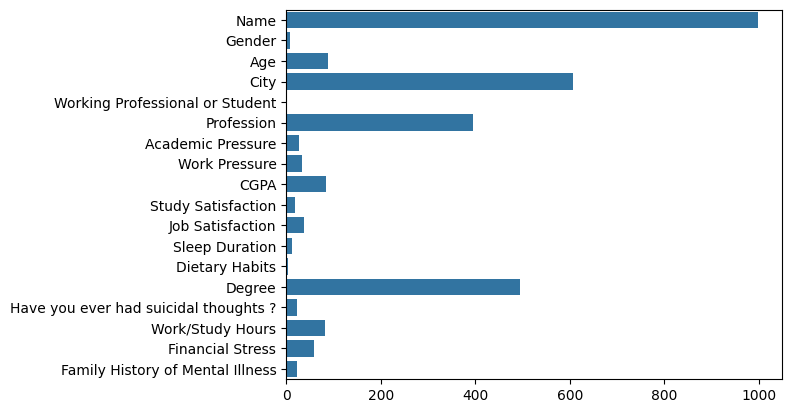

In [6]:
def get_diffs_with_lgb():
    from sklearn.model_selection import ShuffleSplit, cross_validate
    import lightgbm as lgb
    X_cat = df_var.loc[df_var.index.isin(X_all) & (df_var['dtype'] == 'Categorical')].index.tolist()
    X_cont = df_var.loc[df_var.index.isin(X_all) & (df_var['dtype'] == 'Float32')].index.tolist()
    X_lgb = X_cont + X_cat
    
    result = pd.concat([
        df_train[X_all].assign(
            is_train=True
        ),
        df_test[X_all].assign(
            **{i: dproc.rearrange_cat(df_test[i], df_train[i].dtype, lambda cats, val: -1) for i in X_cat}, # test에 train 없는 categories를 없애줍니다.
            is_train=False
        )
    ], axis=0).pipe(
        lambda x: cross_validate(
            lgb.LGBMClassifier(verbose=-1), x[X_all], x['is_train'], cv=ShuffleSplit(n_splits=1, train_size=0.6, random_state=123), 
            return_estimator=True, params={'categorical_feature':X_cat}, scoring='roc_auc'
        )
    )
    return result['estimator'][0].feature_importances_, result['test_score'][0]
feature_importance, roc_auc = sc.cache_result("train_test diff", get_diffs_with_lgb)
sns.barplot(x=feature_importance, y=X_all)
print(roc_auc)

In [7]:
X_cat = df_var.loc[df_var.index.isin(X_all) & (df_var['dtype'] == 'Categorical')].index.tolist()

In [8]:
sc.cache_result('Only_Test_Category',
    lambda : pd.concat([
        df_train[X_cat].apply(lambda x: set(x)).rename('train'),
        df_test[X_cat].apply(lambda x: set(x)).rename('test')
    ], axis=1).apply(
        lambda x: x['test'] - x['train'], axis=1
    )
)

City                                     {Golkata, Rolkata, Chemist, Lawyer, Ghopal, Pr...
Degree                                   {Moham, 5.65, Pune, M.B.Ed, Mechanical Enginee...
Dietary Habits                           {Prachi, Soham, Vivaan, Mealy, 5 Unhealthy, MC...
Family History of Mental Illness                                                        {}
Gender                                                                                  {}
Have you ever had suicidal thoughts ?                                                   {}
Name                                     {Rakav, Shrin, Pritvik, Chibha, Abra, Mahavya,...
Profession                               {M.Pharm, B.Pharm, 3M, City Consultant, Surgeo...
Sleep Duration                           {Meerut, 0, Have_you_ever_had_suicidal_thought...
Working Professional or Student                                                         {}
dtype: object

In [9]:
df_city_freq = sc.cache_result('City_Freq',
    lambda : pd.concat([
        df_train['City'].value_counts().rename('train'),
        df_test['City'].value_counts().rename('test')
    ], axis=1)
)
df_city_freq.loc[df_city_freq.isna().any(axis=1)]

,train,test
City,,
Mihir,7.0,NaN
Nandini,4.0,NaN
Mahi,3.0,NaN
Harsha,3.0,NaN
Molkata,2.0,NaN
...,...,...
Avni,NaN,1.0
Mhopal,NaN,1.0
Less than 5 hours,NaN,1.0


City에는 노이즈가 존재합니다. 이들을 제거할 필요가 있다고 봅니다.


# Rearrange Categorical Variables

In [10]:
def get_city_proc():
    city_cat = pd.CategoricalDtype(['Noise'] + df_city_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 10]).index.tolist())
    return lambda x: dproc.rearrange_cat(x['City'], city_cat, lambda cats, x: x if x in cats else 0).fillna('Noise').rename('City_R')
city_proc = get_city_proc()

In [11]:
df_dietary_freq = sc.cache_result('Dietary Habits',
    lambda : pd.concat([
        df_train['Dietary Habits'].value_counts().rename('train'),
        df_test['Dietary Habits'].value_counts().rename('test')
    ], axis=1)
)
df_dietary_freq.loc[df_dietary_freq.isna().any(axis=1)]

,train,test
Dietary Habits,,
Yes,2.0,NaN
No Healthy,1.0,NaN
Class 12,1.0,NaN
Vegas,1.0,NaN
M.Tech,1.0,NaN
Electrician,1.0,NaN
Hormonal,1.0,NaN
Mihir,1.0,NaN
Less than Healthy,1.0,NaN


In [12]:
def get_dietary_proc():
    dietary_cat = pd.CategoricalDtype(['Noise'] + df_dietary_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 10]).index.tolist())
    to_healty = ['Yes', 'More Healthy', '5 Healthy']
    to_unhealty = ['No', 'No Healthy', 'Less Healthy', 'Less than Healthy', '5 Unhealthy']
    return lambda x: dproc.rearrange_cat(
            x['Dietary Habits'], dietary_cat, 
            lambda cats, x: x if x in cats else 2 if x in to_healty else 1 if x in to_unhealty else 0
        ).fillna('Noise').rename('Dietary Habits_R')
dietary_proc = get_dietary_proc()

In [13]:
df_prof_freq = sc.cache_result('Profession_Freq',
    lambda : pd.concat([
        df_train['Profession'].value_counts().rename('train'),
        df_test['Profession'].value_counts().rename('test')
    ], axis=1)
)
display(df_prof_freq.loc[df_prof_freq.isna().any(axis=1)])
def get_prof_proc():
    prof_cat = pd.CategoricalDtype(['Noise', 'Unknown'] + df_prof_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 10]).index.tolist())
    return lambda x: dproc.rearrange_cat(x['Profession'], prof_cat, lambda cats, x: x if x in cats else 0).fillna('Unknown').rename('Profession_R')
prof_proc = get_prof_proc()

,train,test
Profession,,
Academic,5.0,NaN
BCA,3.0,NaN
MBA,2.0,NaN
Dev,1.0,NaN
BE,1.0,NaN
Family Consultant,1.0,NaN
Visakhapatnam,1.0,NaN
Pranav,1.0,NaN
Moderate,1.0,NaN


In [14]:
df_sleep_freq = sc.cache_result('Sleep_Freq',
    lambda : pd.concat([
        df_train['Sleep Duration'].value_counts().rename('train'),
        df_test['Sleep Duration'].value_counts().rename('test')
    ], axis=1)
)
display(df_sleep_freq.loc[df_sleep_freq.isna().any(axis=1)])
def get_sleep_proc():
    dietary_cat = pd.CategoricalDtype(['Noise'] + df_sleep_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 20]).index.tolist())
    sleep_noise = df_sleep_freq.loc[df_sleep_freq.sum(axis=1) <= 20].index.to_series()
    s_hours = sleep_noise.str.findall('[0-9]+')
    repl_dict = pd.cut(s_hours.loc[s_hours.apply(lambda x: len(x) > 0)].apply(lambda x:[int(i) for i in x]).apply(
        lambda x: 8 if len(x) == 2 and x[0] > x[1] else np.mean(x)
    ), bins=[-np.inf, 5, 7, 8, 20, np.inf], labels= [1, 2, 3, 4, 0], right=False).astype(int).to_dict()
    return lambda x: dproc.rearrange_cat(
        x['Sleep Duration'], dietary_cat, 
        lambda cats, x: x if x in cats else repl_dict.get(x, 0)
    ).fillna('Noise').rename('Sleep Duration_R')
sleep_proc = get_sleep_proc()

,train,test
Sleep Duration,,
6-8 hours,4.0,NaN
No,4.0,NaN
10-11 hours,2.0,NaN
Sleep_Duration,2.0,NaN
45,2.0,NaN
45-48 hours,1.0,NaN
Work_Study_Hours,1.0,NaN
49 hours,1.0,NaN
Pune,1.0,NaN


In [15]:
df_degree_freq = sc.cache_result('Degree_Freq',
    lambda : pd.concat([
        df_train['Degree'].value_counts().rename('train'),
        df_test['Degree'].value_counts().rename('test')
    ], axis=1)
)
display(df_degree_freq.loc[df_degree_freq.isna().any(axis=1)])
def get_degree_proc():
    degree_cat = pd.CategoricalDtype(['Noise'] + df_degree_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 20]).index.tolist())
    return lambda x: dproc.rearrange_cat(x['Degree'], degree_cat, lambda cats, x: x if x in cats else 0).fillna('Noise').rename('Degree_R')
degree_proc = get_degree_proc()

,train,test
Degree,,
UX/UI Designer,4.0,NaN
Kalyan,3.0,NaN
MEd,2.0,NaN
P.Com,2.0,NaN
Jhanvi,2.0,NaN
...,...,...
Pune,NaN,1.0
Bian,NaN,1.0
Kavya,NaN,1.0


In [16]:
df_train['Name'].value_counts().pipe(lambda x: x.loc[x > 20])

df_name_freq = sc.cache_result('Name_Freq',
    lambda : pd.concat([
        df_train['Name'].value_counts().rename('train'),
        df_test['Name'].value_counts().rename('test')
    ], axis=1)
)
display(df_name_freq.loc[df_name_freq.isna().any(axis=1)])
def get_name_proc():
    name_cat = pd.CategoricalDtype(['Noise'] + df_name_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 20]).index.tolist())
    return lambda x: dproc.rearrange_cat(x['Name'], name_cat, lambda cats, x: x if x in cats else 0).fillna('Noise').rename('Name_R')
name_proc = get_name_proc()

,train,test
Name,,
Aarash,3.0,NaN
Tarsh,3.0,NaN
Shivvi,2.0,NaN
Prishti,2.0,NaN
Pradhya,2.0,NaN
...,...,...
Aarhar,NaN,1.0
AHM,NaN,1.0
Managan,NaN,1.0


In [17]:
# 카테고리 처리루틴을 종합하고 train에 적용합니다.
cat_procs_list = [
    (city_proc, 'City에서 train과 test에서 빈도가 10 미만은 Noise 처리합니다.'),
    (dietary_proc, 'Dietary Habits에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, 빈도가 10 미만은 Noise 처리합니다.'),
    (prof_proc, 'Profession에서 train과 test에서 빈도가 10 미만은 Noise 처리합니다.'),
    (sleep_proc, 'Sleep Duration에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, 빈도가 10 미만은 Noise 처리합니다.'),
    (degree_proc, 'Degree에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, 빈도가 10 미만은 Noise 처리합니다.'),
    (name_proc, 'Name에서 train과 test에서 빈도가 20 미만은 Noise 처리합니다.'),
]
df_train_cat_proc, df_cat_proc_var = sc.cache_result('train_cat_procs', lambda : dproc.apply_pd(df_train, cat_procs_list, 'cat_proc'))
df_train = dproc.join_and_assign(df_train, df_train_cat_proc)
df_var = pd.concat([df_var, df_cat_proc_var]).groupby(level=0).last()
del df_cat_proc_var
df_var.query('src == "cat_proc"')

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
City_R,NaN,NaN,0.0,140700.0,31.0,None,None,None,None,None,Categorical,City에서 train과 test에서 빈도가 10 미만은 Noise 처리합니다.,cat_proc,<function get_city_proc.<locals>.<lambda> at 0...
Degree_R,NaN,NaN,0.0,140700.0,28.0,None,None,None,None,None,Categorical,"Degree에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, ...",cat_proc,<function get_degree_proc.<locals>.<lambda> at...
Dietary Habits_R,NaN,NaN,0.0,140700.0,4.0,None,None,None,None,None,Categorical,Dietary Habits에서 train과 test에서 최대한 유사 빈도의 카테고리...,cat_proc,<function get_dietary_proc.<locals>.<lambda> a...
Name_R,NaN,NaN,0.0,140700.0,218.0,None,None,None,None,None,Categorical,Name에서 train과 test에서 빈도가 20 미만은 Noise 처리합니다.,cat_proc,<function get_name_proc.<locals>.<lambda> at 0...
Profession_R,NaN,NaN,0.0,140700.0,38.0,None,None,None,None,None,Categorical,Profession에서 train과 test에서 빈도가 10 미만은 Noise 처리...,cat_proc,<function get_prof_proc.<locals>.<lambda> at 0...
Sleep Duration_R,NaN,NaN,0.0,140700.0,5.0,None,None,None,None,None,Categorical,Sleep Duration에서 train과 test에서 최대한 유사 빈도의 카테고리...,cat_proc,<function get_sleep_proc.<locals>.<lambda> at ...


In [18]:
# 카테고리 처리루틴 후에 test에만 등장하는 카테고리가 있는지를 살펴봅니다.
display(
    sc.cache_result('Only_Test_Category_After_cat_procs',
        lambda : pd.concat([
            df_train_cat_proc.apply(lambda x: set(x)).rename('train'),
            dproc.apply_pd(df_test, cat_procs_list).apply(lambda x: set(x)).rename('test')
        ], axis=1).apply(
            lambda x: x['test'] - x['train'], axis=1
        )
    )
)
del df_train_cat_proc

City_R              {}
Dietary Habits_R    {}
Profession_R        {}
Sleep Duration_R    {}
Degree_R            {}
Name_R              {}
dtype: object

# Target Distribution

In [19]:
df_train[target].value_counts().pipe(lambda x: pd.concat([x, (x / x.sum()).rename('ratio')], axis=1))

,count,ratio
Depression,,
0,115133,0.818287
1,25567,0.181713


무조건 Depression이라고 예측을 해도 0.818 의 정확도를 얻을 수 있습니다.

# Categorical Variables

In [20]:
X_cat = df_var.query('src == "cat_proc"').index.to_list()
X_bool = df_var.query('n_unique == 2 and Description != "Target"').index.to_list()
np.array(X_cat), np.array(X_bool)
X_cat_all = X_cat + X_bool
X_cat_all

['City_R',
 'Degree_R',
 'Dietary Habits_R',
 'Name_R',
 'Profession_R',
 'Sleep Duration_R',
 'Family History of Mental Illness',
 'Gender',
 'Have you ever had suicidal thoughts ?',
 'Working Professional or Student']

## Chi2 Independent Test with target

In [21]:
from scipy.stats import chi2_contingency
df_chi2_result = sc.cache_result('Chi2_test_result',
    lambda : df_train[X_cat_all].apply(lambda x: chi2_contingency(pd.crosstab(x, df_train[target]))).apply(lambda x: pd.Series([x[0], x[1]], index=['stat', 'pvalue']))
).T.sort_values('stat', ascending=False)
df_chi2_result

,stat,pvalue
Profession_R,42058.339673,0.000000e+00
Working Professional or Student,38157.585828,0.000000e+00
Have you ever had suicidal thoughts ?,17142.055358,0.000000e+00
Degree_R,13063.034997,0.000000e+00
Name_R,4498.648616,0.000000e+00
Dietary Habits_R,3243.557753,0.000000e+00
Sleep Duration_R,1195.719459,1.349409e-257
City_R,1055.176825,1.134086e-202
Family History of Mental Illness,38.227325,6.296449e-10
Gender,9.289548,2.304650e-03


In [23]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(5, random_state=123, shuffle=True)

In [54]:
from sklearn.metrics import roc_auc_score, accuracy_score
X = ['Have you ever had suicidal thoughts ?', 'Profession_R', 'Age_2']
for train_idx, test_idx in skf.split(df_train, df_train[target]):
    df_cv_train, df_valid = df_train.iloc[train_idx], df_train.iloc[test_idx]
    s_mean = (df_cv_train.assign(Age_2=lambda x: x['Age'] <= 33).groupby(X, observed=True)[target].mean() > 0.5).astype('int')
    print(
        accuracy_score(df_valid[target], df_valid.assign(Age_2=lambda x: x['Age'] <= 33)[X].apply(tuple,axis=1).map(s_mean).fillna(df_cv_train[target].mode()[0]))
    )

0.9070362473347549
0.9111229566453447
0.9120824449182658
0.912864250177683
0.910270078180526


## Mode/Accuracy

In [23]:
# 그룹별 최빈값으로 예측했을 때의 정확도를 구합니다.
def mode_accuracy():
    s_acc_list = list()
    for i in X_cat_all:
        s_target_mode = df_train.groupby(i, observed=True)[target].apply(lambda x: x.mode()[0])
        s_acc_list.append(accuracy_score(df_train[target], df_train[i].map(s_target_mode)))
    return pd.Series(s_acc_list, index=X_cat_all, name='mode/accuracy')
s_mode_accuracy = sc.cache_result('Mode Accuracy', mode_accuracy)
s_mode_accuracy

City_R                                   0.818287
Degree_R                                 0.820910
Dietary Habits_R                         0.818287
Name_R                                   0.818287
Profession_R                             0.836482
Sleep Duration_R                         0.818287
Family History of Mental Illness         0.818287
Gender                                   0.818287
Have you ever had suicidal thoughts ?    0.818287
Working Professional or Student          0.852196
Name: mode/accuracy, dtype: float64

## Chi2 Independent Test between features

In [24]:
from scipy.spatial.distance import pdist, squareform
chi2_tab = sc.cache_result('Chi2_test_with_features',
    lambda : pdist(df_train[X_cat_all].T, lambda u, v: chi2_contingency(pd.crosstab(u, v))[0])
)
pd.DataFrame(squareform(chi2_tab), index=X_cat_all, columns = X_cat_all)

,City_R,Degree_R,Dietary Habits_R,Name_R,Profession_R,Sleep Duration_R,Family History of Mental Illness,Gender,Have you ever had suicidal thoughts ?,Working Professional or Student
City_R,0.000000,13282.602096,1058.396887,100433.962350,11030.335783,532.831952,217.077020,1314.771425,168.585714,1865.532343
Degree_R,13282.602096,0.000000,1357.855499,82150.671941,581573.375189,513.033711,66.033101,862.428119,1218.514459,6632.736693
Dietary Habits_R,1058.396887,1357.855499,0.000000,4433.494132,1575.356771,86.938022,4.318453,210.096721,615.498831,397.128570
Name_R,100433.962350,82150.671941,4433.494132,0.000000,91764.840894,3378.816317,946.086905,138020.297942,1198.880599,7203.710985
Profession_R,11030.335783,581573.375189,1575.356771,91764.840894,0.000000,652.189054,95.958660,1050.729087,3310.598264,98560.119999
Sleep Duration_R,532.831952,513.033711,86.938022,3378.816317,652.189054,0.000000,4.028703,11.074140,189.903973,107.506921
Family History of Mental Illness,217.077020,66.033101,4.318453,946.086905,95.958660,4.028703,0.000000,33.736193,12.103271,23.967716
Gender,1314.771425,862.428119,210.096721,138020.297942,1050.729087,11.074140,33.736193,0.000000,16.562594,6.202542
Have you ever had suicidal thoughts ?,168.585714,1218.514459,615.498831,1198.880599,3310.598264,189.903973,12.103271,16.562594,0.000000,2666.502431
Working Professional or Student,1865.532343,6632.736693,397.128570,7203.710985,98560.119999,107.506921,23.967716,6.202542,2666.502431,0.000000


In [25]:
# Profession과 Working Professional or Student과 빈도수를 구해봅니다.
sc.cache_result('Conti_Professional_R',
    lambda : df_train.groupby('Working Professional or Student', observed=False)['Profession_R'].apply(lambda x: x.value_counts()).unstack()
)

,Noise,Unknown,Teacher,Content Writer,Architect,Consultant,HR Manager,Pharmacist,Doctor,Business Analyst,...,Civil Engineer,UX/UI Designer,Digital Marketer,Accountant,Finanancial Analyst,Mechanical Engineer,Graphic Designer,Research Analyst,Investment Banker,Student
Working Professional or Student,,,,,,,,,,,,,,,,,,,,,
Working Professional,43,8763,24900,7812,4362,4229,4022,3891,3253,3161,...,1469,1451,1369,1339,1329,1177,1163,690,393,4
Student,0,27867,6,2,8,0,0,2,2,0,...,1,1,3,0,0,0,0,0,0,3


Profession과 Working Professional or Student 에는 일관성이 없는 데이터들이 약간씩 존재합니다. 

In [26]:
pd.crosstab(
    index=df_train[['Working Professional or Student', 'Have you ever had suicidal thoughts ?']].sum(axis=1), 
    columns=df_train[target]
)

Depression,0,1
row_0,,
StudentNo,7866,2379
StudentYes,3699,13957
Working ProfessionalNo,59814,1079
Working ProfessionalYes,43754,8152


In [27]:
pd.crosstab(
    index=df_train[['Working Professional or Student', 'Have you ever had suicidal thoughts ?']].sum(axis=1), 
    columns=df_train[target], normalize='index'
)

Depression,0,1
row_0,,
StudentNo,0.767789,0.232211
StudentYes,0.209504,0.790496
Working ProfessionalNo,0.982280,0.017720
Working ProfessionalYes,0.842947,0.157053


# Numerical Variables

In [28]:
X_cont = df_var.loc[(df_var['Description'] != 'Target') & (df_var['dtype'] == 'Float32')].index.to_list()
df_var.loc[X_cont]

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
Academic Pressure,1.00,5.0,187836.0,46664.0,6.0,True,True,True,True,Float32,Float32,None,org,None
Age,18.00,60.0,0.0,234500.0,43.5,True,True,True,True,Float32,Float32,None,org,None
CGPA,5.03,10.0,187836.0,46664.0,329.5,True,True,True,True,Float32,Float32,None,org,None
Financial Stress,1.00,5.0,4.0,234496.0,5.5,True,True,True,True,Float32,Float32,None,org,None
Job Satisfaction,1.00,5.0,46684.0,187816.0,6.0,True,True,True,True,Float32,Float32,None,org,None
Study Satisfaction,1.00,5.0,187836.0,46664.0,6.0,True,True,True,True,Float32,Float32,None,org,None
Work Pressure,1.00,5.0,46696.0,187804.0,6.0,True,True,True,True,Float32,Float32,None,org,None
Work/Study Hours,0.00,12.0,0.0,234500.0,13.0,True,True,True,True,Float32,Float32,None,org,None


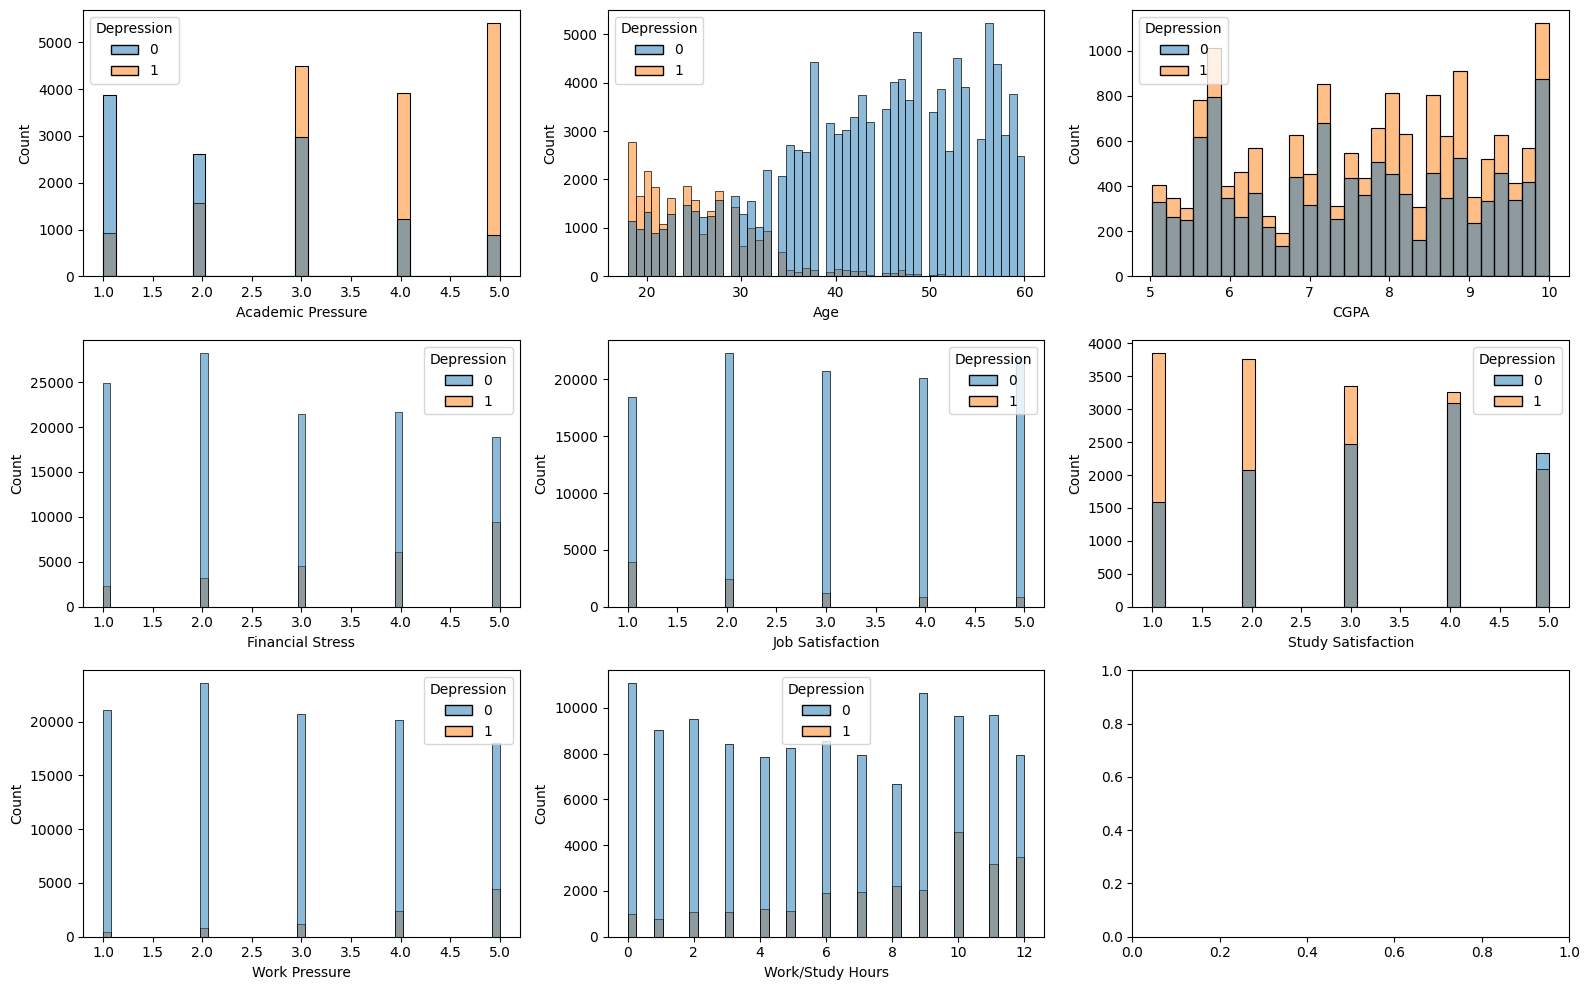

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_train, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [30]:
# CGPA가 가장 상관성이 없어 보입니다. mannwhitnry U 검증을 해봅니다.
from scipy.stats import mannwhitneyu
mannwhitneyu(df_train.loc[df_train[target] == 0, 'CGPA'].dropna(), df_train.loc[df_train[target] == 1, 'CGPA'].dropna())

MannwhitneyuResult(statistic=92054552.5, pvalue=0.00032127284999336757)

In [31]:
df_train[X_cont].corr()

,Academic Pressure,Age,CGPA,Financial Stress,Job Satisfaction,Study Satisfaction,Work Pressure,Work/Study Hours
Academic Pressure,1.000000,-0.075956,-0.025195,0.152105,-1.000000,-0.112228,NaN,0.095650
Age,-0.075956,1.000000,0.005129,-0.083589,0.030793,0.008862,-0.098924,-0.118356
CGPA,-0.025195,0.005129,1.000000,0.006398,1.000000,-0.047078,NaN,0.002875
Financial Stress,0.152105,-0.083589,0.006398,1.000000,-0.029160,-0.065001,0.024412,0.036134
Job Satisfaction,-1.000000,0.030793,1.000000,-0.029160,1.000000,-1.000000,-0.036958,-0.029227
Study Satisfaction,-0.112228,0.008862,-0.047078,-0.065001,-1.000000,1.000000,NaN,-0.036934
Work Pressure,NaN,-0.098924,NaN,0.024412,-0.036958,NaN,1.000000,-0.002808
Work/Study Hours,0.095650,-0.118356,0.002875,0.036134,-0.029227,-0.036934,-0.002808,1.000000


In [32]:
def inconsitency_stat():
    return (
        pd.concat([
            df_train['Working Professional or Student'],
            df_train['Academic Pressure'].isna()
        ], axis=1).value_counts(),
        df_train[['Academic Pressure', 'CGPA', 'Study Satisfaction']].isna().sum(axis=1).value_counts(),
        df_train[['Job Satisfaction', 'Work Pressure']].isna().sum(axis=1).value_counts()
    )
s_ws_ac_freq, s_acs_frwq, s_jw = sc.cache_result('inconsitency_stat', inconsitency_stat)
display(s_ws_ac_freq)
display(s_acs_frwq)
display(s_jw)

Working Professional or Student  Academic Pressure
Working Professional             True                 112794
Student                          False                 27892
                                 True                      9
Working Professional             False                     5
Name: count, dtype: int64

3    112799
0     27892
1         7
2         2
Name: count, dtype: int64

0    112777
2     27905
1        18
Name: count, dtype: int64

Working Professional or Student와 Academic Pressure 는 배타적인 성질을 지닌듯 보입니다. 

'Academic Pressure', 'CGPA', 'Study Satisfaction' 와 'Job Satisfaction', 'Work Pressure'의 값의 유무도 배타적으로 보이고 변수의 이름상으로도 배타성이 있습니다.

'Academic Pressure', 'CGPA', 'Study Satisfaction' 의 결측 유무 또한 All or Nothing 으로 보이는데, 간혹 불일치가 있습니다.

'Job Satisfaction', 'Work Pressure'의 결측 유무 또한 All or Nothing 으로 보이는데, 간혹 불일치가 있습니다.

## 일관성이 없는 경우 조사

In [33]:
df_train.loc[
    (df_train['Working Professional or Student'] == 'Student') & 
    (~df_train['Profession_R'].isin(['Unknown', 'Student']))
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,City_R,Dietary Habits_R,Profession_R,Sleep Duration_R,Degree_R,Name_R
id,,,,,,,,,,,,,,,,,,,,,
609,Anand,Male,21.0,Ahmedabad,Student,Civil Engineer,5.0,NaN,7.83,1.0,...,11.0,3.0,Yes,1,Ahmedabad,Healthy,Civil Engineer,5-6 hours,MSc,Anand
2105,Shreya,Female,31.0,Vadodara,Student,Architect,5.0,NaN,6.95,3.0,...,8.0,1.0,Yes,1,Vadodara,Moderate,Architect,Less than 5 hours,BSc,Shreya
9483,Vidya,Female,32.0,Kalyan,Student,UX/UI Designer,3.0,NaN,9.60,2.0,...,5.0,3.0,No,1,Kalyan,Moderate,UX/UI Designer,7-8 hours,PhD,Vidya
11470,Anjali,Female,28.0,Ahmedabad,Student,Digital Marketer,5.0,NaN,9.72,3.0,...,10.0,5.0,Yes,1,Ahmedabad,Healthy,Digital Marketer,More than 8 hours,MA,Anjali
12425,Rupak,Male,25.0,Kalyan,Student,Content Writer,5.0,NaN,8.50,2.0,...,0.0,2.0,Yes,1,Kalyan,Moderate,Content Writer,5-6 hours,B.Ed,Rupak
16196,Ivaan,Male,33.0,Jaipur,Student,Architect,2.0,NaN,7.13,4.0,...,2.0,5.0,Yes,1,Jaipur,Moderate,Architect,More than 8 hours,MSc,Ivaan
16959,Vidhi,Female,24.0,Mumbai,Student,Architect,3.0,NaN,8.89,5.0,...,3.0,5.0,Yes,1,Mumbai,Unhealthy,Architect,More than 8 hours,MSc,Vidhi
18291,Ritvik,Male,32.0,Agra,Student,Educational Consultant,3.0,NaN,5.74,4.0,...,3.0,5.0,Yes,1,Agra,Healthy,Educational Consultant,7-8 hours,B.Ed,Ritvik
19226,Rupak,Male,31.0,Rajkot,Student,Teacher,3.0,NaN,7.48,5.0,...,12.0,2.0,Yes,1,Rajkot,Unhealthy,Teacher,5-6 hours,MD,Rupak


In [34]:
df_train.loc[
    (df_train['Working Professional or Student'] == 'Working Professional') & 
    (df_train['Profession_R'] == 'Student')
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,City_R,Dietary Habits_R,Profession_R,Sleep Duration_R,Degree_R,Name_R
id,,,,,,,,,,,,,,,,,,,,,
11509,Prisha,Female,22.0,Thane,Working Professional,Student,NaN,3.0,NaN,NaN,...,5.0,2.0,No,0,Thane,Moderate,Student,7-8 hours,B.Com,Prisha
25447,Gaurav,Male,60.0,Pune,Working Professional,Student,NaN,3.0,NaN,NaN,...,8.0,1.0,Yes,0,Pune,Unhealthy,Student,5-6 hours,M.Pharm,Gaurav
73447,Harsha,Male,35.0,Ahmedabad,Working Professional,Student,NaN,4.0,NaN,NaN,...,1.0,3.0,Yes,0,Ahmedabad,Moderate,Student,Less than 5 hours,BSc,Harsha
88617,Ayush,Male,29.0,Srinagar,Working Professional,Student,NaN,4.0,NaN,NaN,...,10.0,1.0,Yes,0,Srinagar,Moderate,Student,5-6 hours,BE,Ayush


In [35]:
df_train.loc[
    df_train[['Academic Pressure', 'CGPA', 'Study Satisfaction']].isna().sum(axis=1).isin([1, 2])
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,City_R,Dietary Habits_R,Profession_R,Sleep Duration_R,Degree_R,Name_R
id,,,,,,,,,,,,,,,,,,,,,
17549,Tanya,Female,20.0,Patna,Student,NaN,NaN,NaN,5.55,NaN,...,0.0,3.0,Yes,0,Patna,Moderate,Unknown,5-6 hours,Class 12,Tanya
18344,Shivam,Male,30.0,Faridabad,Student,NaN,5.0,NaN,5.74,NaN,...,0.0,3.0,Yes,1,Faridabad,Unhealthy,Unknown,Less than 5 hours,MCA,Shivam
52737,Aarav,Male,28.0,Vadodara,Student,NaN,3.0,NaN,NaN,4.0,...,12.0,2.0,No,0,Vadodara,Healthy,Unknown,Less than 5 hours,BBA,Aarav
58062,Ishita,Female,32.0,Vadodara,Student,NaN,5.0,NaN,NaN,NaN,...,11.0,5.0,No,1,Vadodara,Unhealthy,Unknown,Less than 5 hours,Class 12,Ishita
60348,Nishant,Male,29.0,Agra,Working Professional,NaN,NaN,NaN,9.72,2.0,...,7.0,2.0,Yes,0,Agra,Moderate,Unknown,5-6 hours,B.Ed,Nishant
102714,Aahana,Female,18.0,Bhopal,Student,NaN,4.0,NaN,5.88,NaN,...,5.0,1.0,No,1,Bhopal,Moderate,Unknown,Less than 5 hours,Class 12,Aahana
110097,Abhinav,Male,34.0,Pune,Student,NaN,1.0,NaN,NaN,5.0,...,10.0,3.0,Yes,0,Pune,Unhealthy,Unknown,Less than 5 hours,M.Ed,Abhinav
122983,Saanvi,Female,30.0,Ghaziabad,Student,NaN,NaN,NaN,5.47,2.0,...,5.0,1.0,No,0,Ghaziabad,Unhealthy,Unknown,Less than 5 hours,B.Com,Saanvi
137013,Vikram,Male,36.0,Varanasi,Student,NaN,NaN,NaN,8.54,3.0,...,8.0,5.0,Yes,1,Varanasi,Moderate,Unknown,More than 8 hours,Class 12,Vikram


In [36]:
df_train.loc[
    df_train[['Job Satisfaction', 'Work Pressure']].isna().sum(axis=1) == 1
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,City_R,Dietary Habits_R,Profession_R,Sleep Duration_R,Degree_R,Name_R
id,,,,,,,,,,,,,,,,,,,,,
1428,Rishi,Male,29.0,Srinagar,Student,NaN,3.0,NaN,9.63,3.0,...,8.0,5.0,No,0,Srinagar,Moderate,Unknown,7-8 hours,M.Pharm,Rishi
15846,Shrey,Male,53.0,Vasai-Virar,Working Professional,NaN,NaN,NaN,NaN,NaN,...,12.0,1.0,No,0,Vasai-Virar,Unhealthy,Unknown,More than 8 hours,Class 12,Shrey
25647,Ishwar,Male,57.0,Kalyan,Working Professional,NaN,NaN,1.0,NaN,NaN,...,4.0,1.0,No,0,Kalyan,Unhealthy,Unknown,Less than 5 hours,Class 12,Ishwar
52199,Manan,Male,50.0,Agra,Working Professional,NaN,NaN,4.0,NaN,NaN,...,1.0,3.0,Yes,0,Agra,Unhealthy,Unknown,5-6 hours,Class 12,Manan
55222,Trisha,Female,21.0,Varanasi,Working Professional,NaN,NaN,5.0,NaN,NaN,...,11.0,2.0,Yes,0,Varanasi,Moderate,Unknown,7-8 hours,B.Arch,Trisha
65346,Monika,Female,18.0,Faridabad,Working Professional,NaN,NaN,5.0,NaN,NaN,...,9.0,5.0,No,1,Faridabad,Moderate,Unknown,5-6 hours,Class 12,Monika
70453,Veda,Female,20.0,Ahmedabad,Student,NaN,NaN,NaN,NaN,NaN,...,12.0,3.0,Yes,1,Ahmedabad,Moderate,Unknown,Less than 5 hours,Class 12,Veda
76104,Vanya,Female,20.0,Nashik,Working Professional,NaN,NaN,NaN,NaN,NaN,...,11.0,1.0,No,1,Nashik,Moderate,Unknown,7-8 hours,Class 12,Vanya
85126,Monika,Female,27.0,Kanpur,Working Professional,Mechanical Engineer,NaN,NaN,NaN,NaN,...,10.0,5.0,No,1,Kanpur,Healthy,Mechanical Engineer,5-6 hours,BE,Monika


In [37]:
df_train.loc[
    (df_train['Working Professional or Student'] == 'Student') & 
    (df_train[['Job Satisfaction', 'Work Pressure']].notna().any(axis=1))
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,City_R,Dietary Habits_R,Profession_R,Sleep Duration_R,Degree_R,Name_R
id,,,,,,,,,,,,,,,,,,,,,
1428,Rishi,Male,29.0,Srinagar,Student,NaN,3.0,NaN,9.63,3.0,...,8.0,5.0,No,0,Srinagar,Moderate,Unknown,7-8 hours,M.Pharm,Rishi
21880,Aarush,Male,38.0,Chennai,Student,NaN,NaN,5.0,NaN,NaN,...,2.0,3.0,No,0,Chennai,Healthy,Unknown,5-6 hours,Class 12,Aarush
70453,Veda,Female,20.0,Ahmedabad,Student,NaN,NaN,NaN,NaN,NaN,...,12.0,3.0,Yes,1,Ahmedabad,Moderate,Unknown,Less than 5 hours,Class 12,Veda
75007,Aarav,Male,21.0,Lucknow,Student,NaN,NaN,2.0,NaN,NaN,...,3.0,3.0,Yes,0,Lucknow,Moderate,Unknown,7-8 hours,Class 12,Aarav
105773,Anand,Male,18.0,Ahmedabad,Student,NaN,NaN,NaN,NaN,NaN,...,9.0,5.0,No,1,Ahmedabad,Moderate,Unknown,Less than 5 hours,Class 12,Anand
116703,Neil,Male,25.0,Bangalore,Student,NaN,4.0,NaN,9.44,5.0,...,4.0,1.0,No,1,Bangalore,Unhealthy,Unknown,Less than 5 hours,PhD,Neil
129756,Kian,Male,18.0,Rajkot,Student,NaN,NaN,5.0,NaN,NaN,...,9.0,4.0,No,1,Rajkot,Moderate,Unknown,7-8 hours,Class 12,Kian
134830,Aaradhya,Female,24.0,Meerut,Student,NaN,NaN,NaN,NaN,NaN,...,0.0,5.0,No,0,Meerut,Unhealthy,Unknown,More than 8 hours,Class 12,Aaradhya


In [38]:
df_train.loc[
    (df_train['Working Professional or Student'] != 'Student') & 
    (df_train[['Academic Pressure', 'CGPA', 'Study Satisfaction']].notna().any(axis=1))
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,City_R,Dietary Habits_R,Profession_R,Sleep Duration_R,Degree_R,Name_R
id,,,,,,,,,,,,,,,,,,,,,
18752,Aarti,Female,18.0,Kalyan,Working Professional,NaN,2.0,NaN,8.14,5.0,...,7.0,1.0,Yes,1,Kalyan,Healthy,Unknown,Less than 5 hours,Class 12,Aarti
41915,Advait,Male,18.0,Kolkata,Working Professional,NaN,4.0,NaN,8.04,3.0,...,1.0,5.0,Yes,1,Kolkata,Healthy,Unknown,5-6 hours,Class 12,Advait
55827,Prachi,Female,19.0,Kalyan,Working Professional,NaN,3.0,NaN,8.11,2.0,...,4.0,4.0,No,1,Kalyan,Unhealthy,Unknown,5-6 hours,Class 12,Prachi
60348,Nishant,Male,29.0,Agra,Working Professional,NaN,NaN,NaN,9.72,2.0,...,7.0,2.0,Yes,0,Agra,Moderate,Unknown,5-6 hours,B.Ed,Nishant
99062,Tanisha,Female,24.0,Surat,Working Professional,Content Writer,4.0,NaN,5.42,4.0,...,1.0,5.0,No,1,Surat,Moderate,Content Writer,Less than 5 hours,B.Ed,Tanisha
101189,Keshav,Male,34.0,Rajkot,Working Professional,NaN,4.0,NaN,8.24,3.0,...,11.0,1.0,No,0,Rajkot,Moderate,Unknown,More than 8 hours,MD,Keshav


In [97]:
na_cnt1_proc = lambda x: x[['Academic Pressure', 'CGPA', 'Study Satisfaction']].isna().sum(axis=1).astype('int8').rename('na_cnt1')
na_cnt2_proc = lambda x: x[['Job Satisfaction', 'Work Pressure']].isna().sum(axis=1).astype('int8').rename('na_cnt2')
inconsistent1_proc = lambda x: ((x['Working Professional or Student'] == 'Student') & (~x['Profession_R'].isin(['Unknown', 'Student']))).rename('inconsistent1')
prof_r2_proc = lambda x: x['Profession_R'].where(x['Working Professional or Student'] == 'Working Professional', 'Student').rename('Profession_R2')

inconsi_procs = [
    (na_cnt1_proc, "Student와 관련된 수치의 결측의 수"),
    (na_cnt2_proc, "Working Professional 와 관련된 수치의 결측의 수"),
    (inconsistent1_proc, "'Working Professional or Student'와 'Profession_R' 사이의 모순 여부"),
    (prof_r2_proc, "'Working Professional or Student'가 Student이면 'Profession_R'을 Student로 치환합니다")
]
df_inconsi, df_inconsi_var = sc.cache_result('inconsi_proc1', lambda : dproc.apply_pd(df_train, inconsi_procs, 'inconsi'))
df_train = dproc.join_and_assign(df_train, df_inconsi)
df_var = pd.concat([df_var, df_inconsi_var], axis=0).groupby(level=0).last()
del df_inconsi, df_inconsi_var

In [98]:
consistent1_proc = lambda x: x['na_cnt1'].isin([1, 2]).rename('consistent1')
consistent2_proc = lambda x: (x['na_cnt2'] == 1).rename('consistent2')
inconsi_procs2 = [
    (consistent1_proc, "na_cnt1에서 결측 여부의 모순 여부"),
    (consistent2_proc, "na_cnt2에서 결측 여부의 모순 여부"),
]

df_inconsi, df_inconsi_var = sc.cache_result('inconsi_proc2', lambda : dproc.apply_pd(df_train, inconsi_procs2, 'inconsi2'))
df_train = dproc.join_and_assign(df_train, df_inconsi)
df_var = pd.concat([df_var, df_inconsi_var], axis=0).groupby(level=0).last()
del df_inconsi, df_inconsi_var
df_var.query("src=='inconsi2'")

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
consistent1,False,True,0.0,140700.0,2.0,True,True,True,True,None,Bool,na_cnt1에서 결측 여부의 모순 여부,inconsi2,<function <lambda> at 0x7fd768c1b880>
consistent2,False,True,0.0,140700.0,2.0,True,True,True,True,None,Bool,na_cnt2에서 결측 여부의 모순 여부,inconsi2,<function <lambda> at 0x7fd768aa6c00>


## Fillna

In [101]:
def get_fillna_mode_proc(s, t):
    m = s.mode().iloc[0]
    return lambda x: x[s.name].fillna(m).rename(s.name + '_FM').astype(t)

def get_fillna_zero_proc(var_name, t):
    return lambda x: x[var_name].fillna(0).rename(var_name + '_FZ').astype(t)

fillna_proc = [
    (get_fillna_zero_proc(a, b), '{}의 결측을 0으로 채운 변수입니다.'.format(a)) for a, b in [
        ('Academic Pressure', 'int8'), ('CGPA', 'float32'), ('Study Satisfaction', 'int8'), ('Job Satisfaction', 'int8'), ('Work Pressure', 'int8')
    ]
]

fillna_proc.append(
    (get_fillna_mode_proc(df_train['Financial Stress'], 'int8'), '{} 최빈값으로 채웁니다.'.format('Financial Stress'))
)
df_fillna, df_fillna_var = sc.cache_result('fillna_proc', lambda : dproc.apply_pd(df_train, fillna_proc, 'fillna'))
df_train = dproc.join_and_assign(df_train, df_fillna)
df_var = pd.concat([df_var, df_fillna_var]).groupby(level=0).last()
df_var

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
Academic Pressure,1.0,5.0,187836.0,46664.0,6.0,True,True,True,True,Float32,Float32,None,org,None
Academic Pressure_FZ,0.0,5.0,0.0,140700.0,6.0,True,True,True,True,None,Int8,Academic Pressure의 결측을 0으로 채운 변수입니다.,fillna,<function get_fillna_zero_proc.<locals>.<lambd...
Age,18.0,60.0,0.0,234500.0,43.5,True,True,True,True,Float32,Float32,None,org,None
CGPA,5.03,10.0,187836.0,46664.0,329.5,True,True,True,True,Float32,Float32,None,org,None
CGPA_FZ,0.0,10.0,0.0,140700.0,332.0,True,True,True,True,None,Float32,CGPA의 결측을 0으로 채운 변수입니다.,fillna,<function get_fillna_zero_proc.<locals>.<lambd...
City,None,None,0.0,234500.0,83.0,True,True,True,True,Categorical,Categorical,None,org,None
City_R,None,None,0.0,140700.0,31.0,None,None,None,None,None,Categorical,City에서 train과 test에서 빈도가 10 미만은 Noise 처리합니다.,cat_proc,<function get_city_proc.<locals>.<lambda> at 0...
Degree,None,None,4.0,234496.0,102.0,True,True,True,True,Categorical,Categorical,None,org,None
Degree_R,None,None,0.0,140700.0,28.0,None,None,None,None,None,Categorical,"Degree에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, ...",cat_proc,<function get_degree_proc.<locals>.<lambda> at...
Depression,0.0,1.0,0.0,140700.0,2.0,True,True,True,True,Int8,Int8,Target,org,None


## Kruskal Test

In [325]:
from scipy.stats import kruskal

X_cat = [
    'City_R', 'Degree_R', 'Dietary Habits_R', 'Name_R', 'Profession_R', 'Sleep Duration_R',
    'Family History of Mental Illness', 'Gender', 'Have you ever had suicidal thoughts ?', 'Working Professional or Student'
]
result = sc.cache_result(
    'kruskal', 
    lambda : df_train[['Academic Pressure', 'CGPA','Financial Stress', 'Job Satisfaction', 'Study Satisfaction', 'Work Pressure', 'Age', 'Work/Study Hours']].apply(
        lambda x: pd.Series([kruskal(*x.groupby(df_train[i], observed=True).agg(lambda x: x.dropna().tolist() ))[0] for i in X_cat], index=X_cat) , axis = 0
    )
)
result

,Academic Pressure,CGPA,Financial Stress,Job Satisfaction,Study Satisfaction,Work Pressure,Age,Work/Study Hours
City_R,203.688798,290.994181,219.735846,189.877510,112.507119,115.659703,1791.443417,237.256941
Degree_R,241.345148,166.730536,451.840822,166.320089,160.144650,864.274595,21870.504128,526.613743
Dietary Habits_R,232.445339,0.288739,357.766437,91.127993,18.193555,87.427217,752.583606,133.132763
Name_R,442.928937,769.012539,831.408459,820.277822,470.851085,888.252921,7092.189078,866.941080
Profession_R,NaN,NaN,695.938076,359.667031,NaN,955.435611,55686.935323,2080.207329
Sleep Duration_R,61.149494,14.060807,12.310234,30.877497,10.748947,78.619647,557.475494,82.118837
Family History of Mental Illness,24.698151,0.481726,2.137260,18.173285,0.464813,6.027281,12.079138,19.479157
Gender,13.850568,36.155370,8.998682,7.293955,6.960415,0.150928,5.363696,6.892421
Have you ever had suicidal thoughts ?,1880.676551,1.911745,1079.810704,349.844140,194.814228,265.370836,2429.932936,587.308626
Working Professional or Student,0.154970,0.225162,391.655760,1.421908,0.148269,1.501902,44884.720807,1917.321714


# Feature Analysis

In [150]:
print(i, roc_auc_score(df_train[target], df_train.groupby('Have you ever had suicidal thoughts ?', observed=True)[target].transform('mean')))

40 0.7262947066582899


In [148]:
from sklearn.metrics import roc_auc_score
for i in range(20, 41):
    print(i, roc_auc_score(df_train[target], df_train.groupby(df_train['Age'] <= i)[target].transform('mean')))

20 0.6147200822970631
21 0.6468106582441663
22 0.6638408243162452
23 0.6899157016463304
24 0.7201089154405009
25 0.7451170946023241
26 0.7568504206354035
27 0.777933974928408
28 0.8056198959745695
29 0.826417877345042
30 0.8328841815340718
31 0.8456658675098488
32 0.856077403100004
33 0.864834609450988
34 0.8657557882848992
35 0.8563878924055968
36 0.8469914222140966
37 0.8390572052457748
38 0.8224391511352607
39 0.8103521618713317
40 0.8006438127518443


In [206]:
age2_proc = lambda x: (x['Age'] <= 34).rename('Age_2')
df_train['Age_2'] = age2_proc(df_train)

In [141]:
pd.concat([
    df_train.groupby('Profession_R2', observed=True)[target].mean().rename('prob'),
    df_train['Profession_R2'].value_counts().rename('count')
], axis=1).sort_values('prob', ascending=False)

,prob,count
Profession_R2,,
Student,0.585415,27905
Unknown,0.375100,8763
Graphic Designer,0.185727,1163
Judge,0.108645,1712
HR Manager,0.106912,4022
Mechanical Engineer,0.101105,1177
Architect,0.097662,4362
Noise,0.093023,43
Financial Analyst,0.083227,1574


In [151]:
df_train.groupby(df_train['Profession_R2'] == 'Unknown')['Age'].mean()

Profession_R2
False    41.086193
True     29.885883
Name: Age, dtype: float32

In [102]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import sgml

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction, stratify=x[target])

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index=df.index),
    'score_func': lambda df, prds: accuracy_score(df[target].sort_index(), prds.sort_index() > 0.5),
    'validation_splitter': get_validation_splitter,
    'y': target,
}

lgb_adapter = sgml.LGBMAdapter(model=lgb.LGBMClassifier)
xgb_adapter = sgml.XGBAdapter(model=xgb.XGBClassifier) 
cb_adapter = sgml.CBAdapter(model=cb.CatBoostClassifier)
dt_adapter = sgml.SklearnAdapter(DecisionTreeClassifier)
lr_adapter = sgml.SklearnAdapter(LogisticRegression)


def print_metrics(title, m):
    print("Accuracy, {}: {:.5f}±{:.5f}".format(
        title, np.mean(m), np.std(m)
    ))

sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
ss = ShuffleSplit(n_splits=1, train_size=0.8, random_state=123)

X_lgb_cat = df_var.drop(index=target).query('src == "cat_proc"').index.tolist()
X_lgb_num_fn = df_var.drop(index=target).query('src == "fillna"').index.tolist()
X_lgb_num_na = df_var.drop(index=target).query('dtype == "Float32" and na > 0').index.tolist()
X_lgb_num = ['Age', 'Work/Study Hours']
X_lgb_bool = df_var.drop(index=target).query('src == "org" and n_unique == 2').index.to_list()
X_lgb_inconsi = df_var.drop(index=target).query('src == "inconsi" and dtype != "Categorical"').index.tolist()
X_lgb_cat, X_lgb_num_fn, X_lgb_num_na, X_lgb_num, X_lgb_bool, X_lgb_inconsi

(['City_R',
  'Degree_R',
  'Dietary Habits_R',
  'Name_R',
  'Profession_R',
  'Sleep Duration_R'],
 ['Academic Pressure_FZ',
  'CGPA_FZ',
  'Financial Stress_FM',
  'Job Satisfaction_FZ',
  'Study Satisfaction_FZ',
  'Work Pressure_FZ'],
 ['Academic Pressure',
  'CGPA',
  'Financial Stress',
  'Job Satisfaction',
  'Study Satisfaction',
  'Work Pressure'],
 ['Age', 'Work/Study Hours'],
 ['Family History of Mental Illness',
  'Gender',
  'Have you ever had suicidal thoughts ?',
  'Working Professional or Student'],
 ['inconsistent1', 'na_cnt1', 'na_cnt2'])

# Simple Estimators

## Decision Tree

3 Depth Decision Tree로 살펴서 어떤 속성이 target을 예측하기 위한 키요소가 되는지 분석해봅니다.

In [342]:
hparams = {
    'model_params': {'max_depth': 3, 'criterion': 'entropy'},
    'X_num':  ['Academic Pressure_FZ', 'CGPA_FZ', 'Financial Stress_FM', 'Job Satisfaction_FZ', 'Study Satisfaction_FZ', 'Work Pressure_FZ', 'Age', 'Work/Study Hours'],
    'X_ohe': ['City_R', 'Degree_R', 'Dietary Habits_R', 'Name_R', 'Profession_R2', 'Sleep Duration_R', 'Gender', 'Family History of Mental Illness', 'Have you ever had suicidal thoughts ?', 'Working Professional or Student'],
    'ohe': {'drop': 'if_binary'}
}

result = sc.cache_result('simple_dt', lambda : sgml.cv(df_train, skf, hparams, config, dt_adapter, result_proc=sgml.m_learning_result))

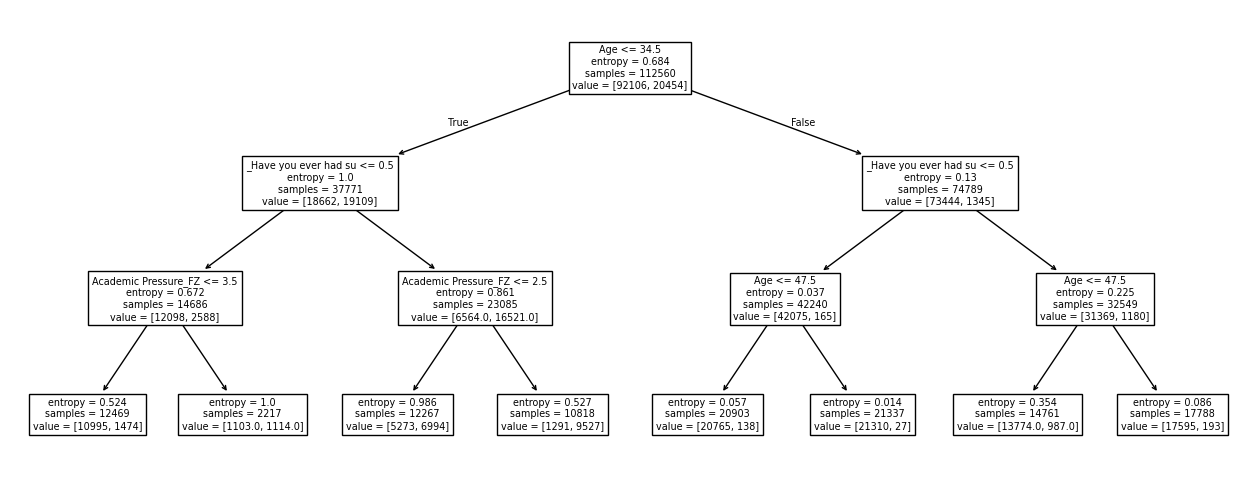

[0.903091684434968, 0.9063965884861407, 0.9074271499644634, 0.9078535891968728, 0.9042999289267946]


In [343]:
from sklearn.tree import plot_tree
plt.figure(figsize=(16, 6))
plot_tree(result['model_result'][0]['model'], feature_names=[i[4: 25] for i in result['model_result'][0]['variables']])
plt.show()
print(result['valid_scores'])

Age와 Have you ever had suicidal ... ? 이 주요소이고, Academic Pressure 권에 잡혔습니다.

##  Logistic Regression

In [360]:
hparams = {
    'model_params': {},
    'X_mm':  ['Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work/Study Hours'],
    'X_ohe': ['Have you ever had suicidal thoughts ?'],
    'ohe': {'drop': 'first'}
}

result = sc.cache_result(
    'simple_lr',
    lambda : sgml.cv(df_train, skf, hparams, config, lr_adapter, result_proc=sgml.m_learning_result)
)

In [361]:
np.mean(result['valid_scores']) , result['model_result'][0]['model'].coef_

(0.9353447050461975,
 array([[-7.06938043,  4.48139324,  2.18745294,  2.96771909, -1.17809975,
         -2.70283091,  1.57191566,  2.4744028 ]]))

In [247]:
hparams = {
    'model_params': {},
    'X_num':  ['Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work/Study Hours'],
    'X_ohe': ['Age_2', 'Have you ever had suicidal thoughts ?'],
    'ohe': {'drop': 'first'}
}

result = sc.cache_result(
    'simple_lr2',
    lambda : sgml.cv(df_train, skf, hparams, config, lr_adapter, result_proc=sgml.m_learning_result)
)

In [246]:
np.mean(result['valid_scores']) , result['model_result'][0]['model'].coef_

(0.9309026297085998,
 array([[ 3.71665346,  2.43386455,  0.84419967,  0.55232354,  0.62930351,
         -0.22448685, -0.50342229,  0.12978857]]))

In [284]:
result_lr = sc.cache_result(
    'simple_lr',
    lambda : sgml.cv(df_train, skf, hparams, config, lr_adapter, result_proc=sgml.m_learning_result)
)
df_train['proba'] = result_lr['valid_prd']

In [502]:
(
    df_train.query('proba < 0.25 or proba > 0.75').pipe(
        lambda x: x[target] != (x['proba'] > 0.5)
    ).mean(),
    df_train.query('proba > 0.25 and proba < 0.75').pipe(
        lambda x: x[target] == (x['proba'] > 0.5)
    ).mean()
)

(0.03172665304940561, 0.636096277377912)

In [503]:
df_confusing = df_train.query('proba > 0.25 and proba < 0.75')
df_confusing[target].value_counts(normalize=True)

Depression
1    0.50089
0    0.49911
Name: proportion, dtype: float64

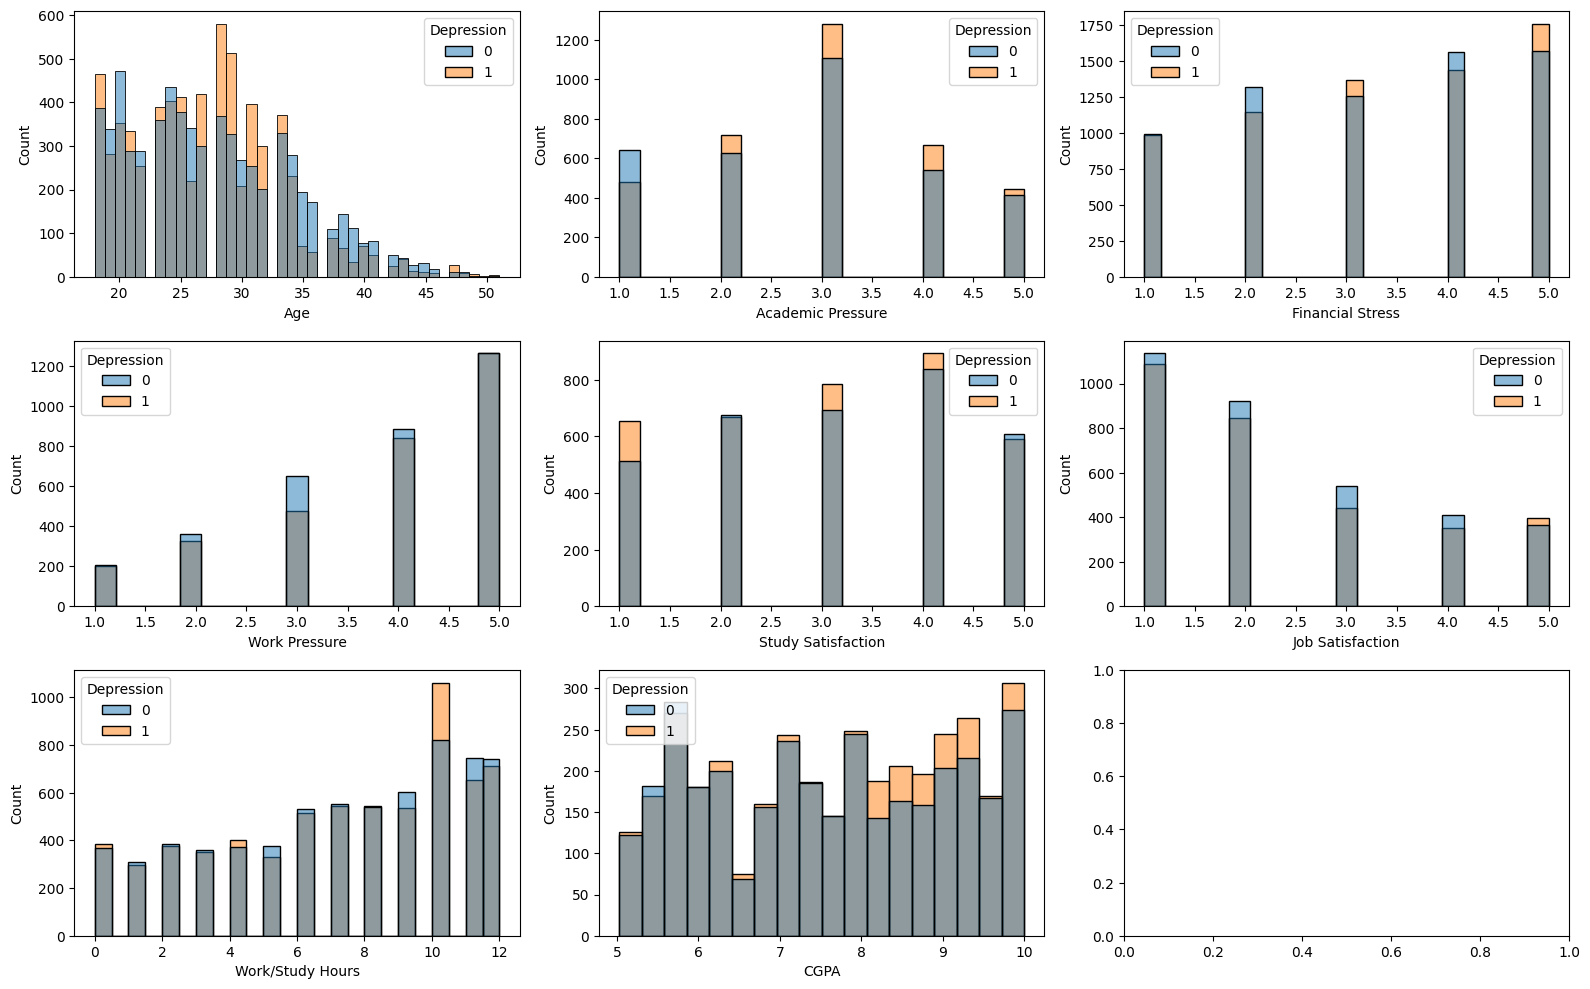

In [301]:
X_cont = ['Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'CGPA']
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_confusing, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

Work/Study Hours가 10인 경우 유난히 Peak에 있습니다.

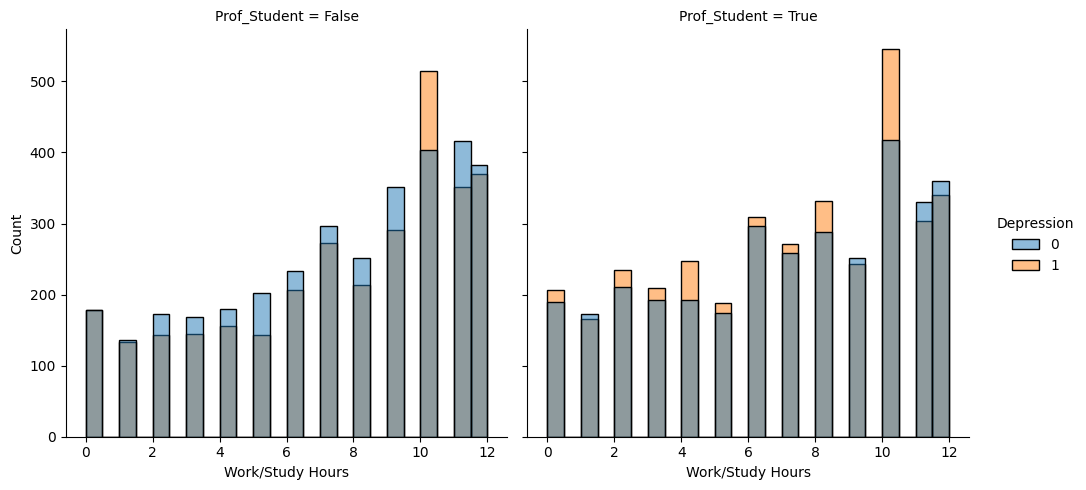

In [337]:
sns.displot(df_confusing.assign(Prof_Student=lambda x: x['Profession_R2'] == 'Student'), x='Work/Study Hours', col='Prof_Student', hue=target)
plt.show()

Work/Study Hours 에서, Work가 주는 의미와 Study가 Depression에 주는 의미가 각각 다르다고 봅니다.

이를 Work Hours와 Study Hours로 나누어 선형 회귀 모델로 만들어 볼 만합니다.

In [366]:
hours_proc = lambda x: pd.concat([
                (x['Work/Study Hours'] * (x['Working Professional or Student'] == 'Working Professional')).astype('int').rename('Work Hours'),
                (x['Work/Study Hours'] * (x['Working Professional or Student'] == 'Student')).astype('int').rename('Study Hours'),
                (x['Work/Study Hours'] == 10).rename('WS_10')
], axis=1)

df_train[['Work Hours', 'Study Hours', 'WS_10']]  = hours_proc(df_train)

In [379]:
hparams = {
    'model_params': {},
    'X_mm':  ['Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 'Study Hours', 'CGPA_FZ'],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'WS_10'],
    'ohe': {'drop': 'first'}
}

result = sc.cache_result(
    'simple_lr2',
    lambda : sgml.cv(df_train, skf, hparams, config, lr_adapter, result_proc=sgml.m_learning_result)
)
np.mean(result['valid_scores'])

0.9355152807391613

/home/sun9sun9/python312/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/sun9sun9/python312/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


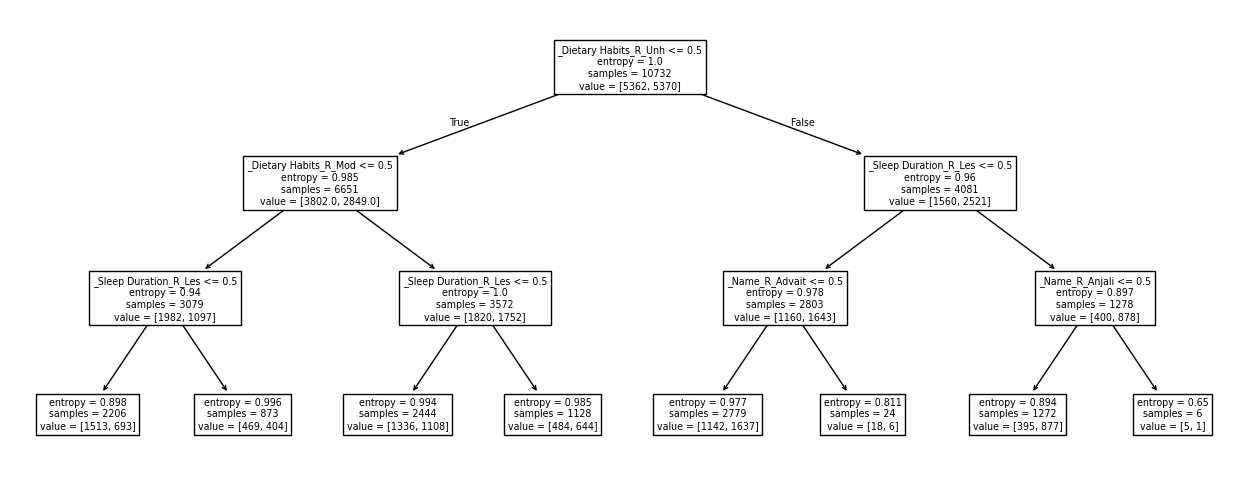

[0.6125186289120715, 0.606038017144987, 0.6127469250838613, 0.5859112933283638, 0.6120014908684308]


In [390]:
hparams = {
    'model_params': {'max_depth': 3, 'criterion': 'entropy'},
    'X_ohe': ['City_R', 'Degree_R', 'Dietary Habits_R', 'Name_R', 'Sleep Duration_R', 'Gender', 'Family History of Mental Illness'],
    'ohe': {'drop': 'if_binary', 'handle_unknown': 'ignore'}
}

result = sc.cache_result('confusing_dt', lambda : sgml.cv(df_confusing, skf, hparams, config, dt_adapter, result_proc=sgml.m_learning_result), 1)
from sklearn.tree import plot_tree
plt.figure(figsize=(16, 6))
plot_tree(result['model_result'][0]['model'], feature_names=[i[4: 25] for i in result['model_result'][0]['variables']])
plt.show()
print(result['valid_scores'])

In [400]:
ord_proc =lambda x: pd.concat([
    x['Dietary Habits_R'].map({'Moderate': 0, 'Unhealthy': -1, 'Healthy': 1}).fillna(0).astype('int').rename('Dietary_level'),
    x['Sleep Duration_R'].map({'Less than 5 hours': -2, '5-6 hours': -1, '7-8 hours': 1, 'More than 8 hours': 2}).fillna(0).astype('int').rename('Sleep_level')
], axis=1)
df_train[['Dietary_level', 'Sleep_level']] = ord_proc(df_train)

In [414]:
hparams = {
    'model_params': {},
    'X_mm':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness'],
    'ohe': {'drop': 'first'}
}

result = sc.cache_result(
    'simple_lr3',
    lambda : sgml.cv(df_train, skf, hparams, config, lr_adapter, result_proc=sgml.m_learning_result)
)
np.mean(result['valid_scores'])

0.9377683013503908

In [547]:
hparams = {
    'model_params': {},
    'X_mm':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Name_R', 'Profession_R2', 'Age_2'],
    'ohe': {'drop': 'first', 'min_frequency': 50}
}

result = sc.cache_result(
    'simple_lr4',
    lambda : sgml.cv(df_train, skf, hparams, config, lr_adapter, result_proc=sgml.m_learning_result)
)
np.mean(result['valid_scores']), np.mean(result['train_scores'])

(0.9392537313432836, 0.9405685856432126)

In [548]:
pd.Series(result['model_result'][0]['model'].coef_[0], index=result['model_result'][0]['variables']).abs().sort_values(ascending=False).iloc[:30]

mm__Age                                           5.337654
mm__Academic Pressure_FZ                          4.233613
mm__Work Pressure_FZ                              3.150406
mm__Job Satisfaction_FZ                           2.697544
ohe__Have you ever had suicidal thoughts ?_Yes    2.462951
mm__Financial Stress_FM                           2.217385
mm__Work Hours                                    1.654525
ohe__Name_R_Saurav                                1.412337
mm__Study Hours                                   1.277093
mm__Study Satisfaction_FZ                         1.184542
ohe__Name_R_Ishan                                 1.142330
ohe__Profession_R2_Chemist                        1.133910
ohe__Age_2_True                                   1.074501
mm__Dietary_level                                 1.042836
ohe__Name_R_Pari                                  1.036775
ohe__Name_R_Ishita                                1.017066
ohe__Name_R_Shanaya                               1.0044

In [549]:
df_train['proba'] = result['valid_prd']
df_confusing = df_train.query('proba > 0.25 and proba < 0.75')
df_confusing[target].value_counts(normalize=True)

Depression
0    0.500687
1    0.499313
Name: proportion, dtype: float64

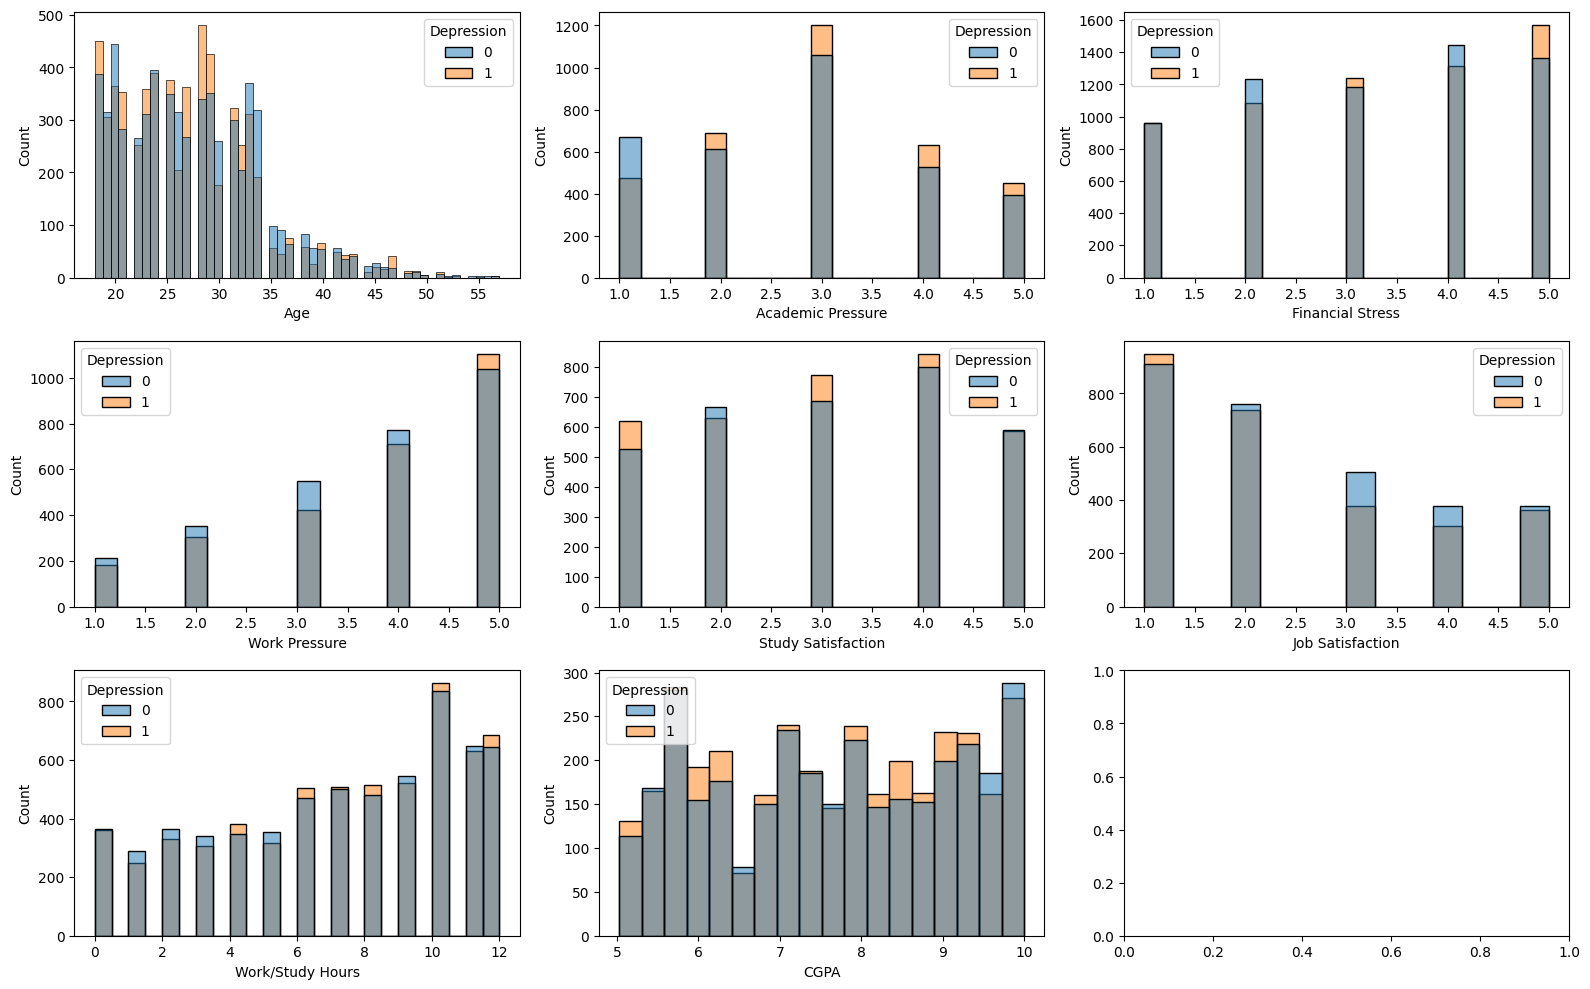

In [550]:
X_cont = ['Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'CGPA']
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_confusing, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

# LGBM

In [692]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.02, 'num_leaves': 15, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    'validation_fraction': 0.1
}

result = sc.cache_result(
    'simple_lgb',
    lambda : sgml.cv(df_train, skf, hparams, config, lgb_adapter), 1
)
np.mean(result['valid_scores']), np.mean(result['train_scores'])

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

(0.9402345415778252, 0.9464658848614071)

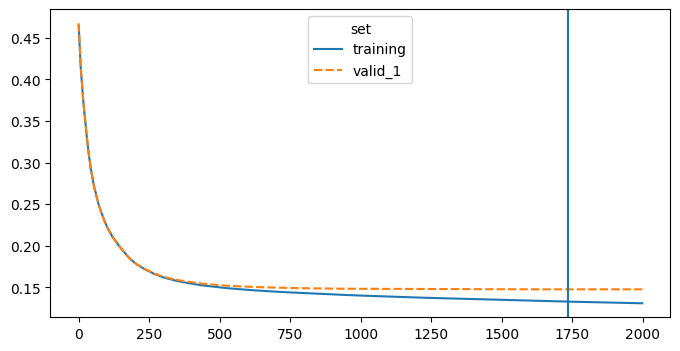

In [693]:
plt.figure(figsize=(8, 4))
valid_result = pd.concat([i['valid_result'] for i in result['model_result']], axis=1).T.groupby(level=1).mean().T
sns.lineplot(valid_result)
plt.axvline(valid_result['valid_1'].idxmin())
plt.show()

## SHAP Analysis

In [694]:
import shap
shap.initjs()

In [695]:
c, X = sc.cache_result(
    'LGBM_shap',
    lambda : sgml.train(df_train, hparams, config, lgb_adapter, result_proc = sgml.m_learning_result)
)

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

In [702]:
explainer = sc.cache_result(
    'lgb_shap_explainer', lambda : shap.TreeExplainer(c['model'])
)

In [704]:
def get_shap_values():
    ct = c['preprocessor']
    df_sub = df_train.sample(frac=0.05, random_state=123)
    X = pd.DataFrame(ct.transform(df_sub).todense(), index=df_sub.index, columns=c['variables'])
    shap_values = explainer.shap_values(X)
    return shap_values, df_sub, X

shap_values, df_sub, X = sc.cache_result(
    'lgb_shap_values', get_shap_values
)

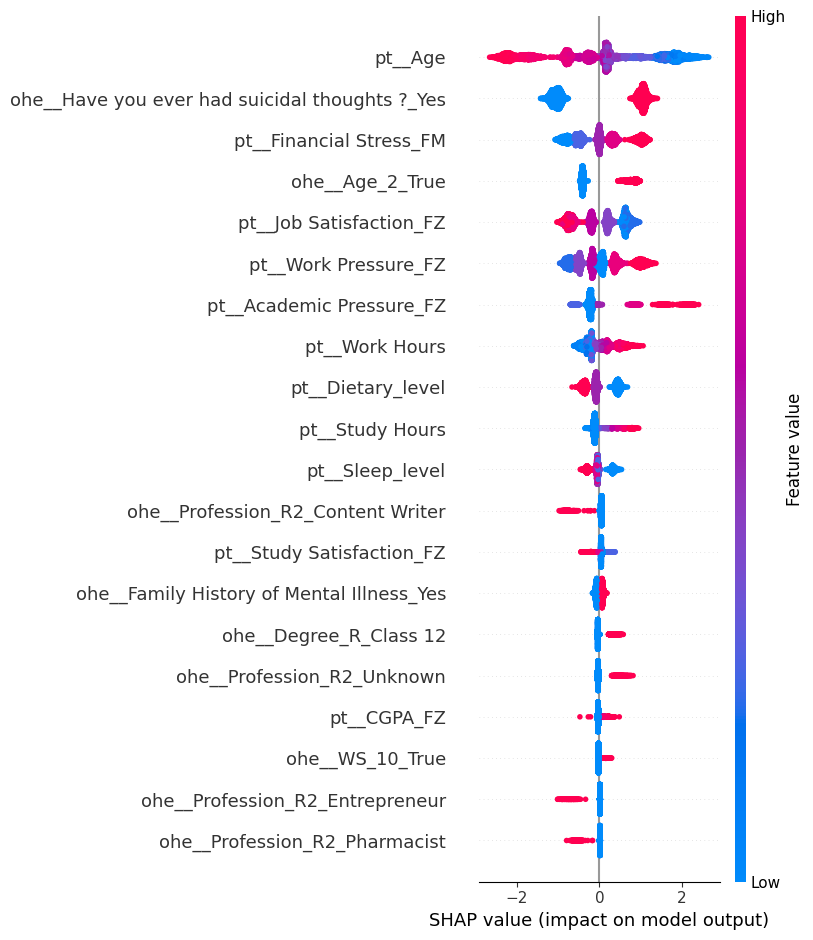

In [705]:
shap.summary_plot(shap_values, X)

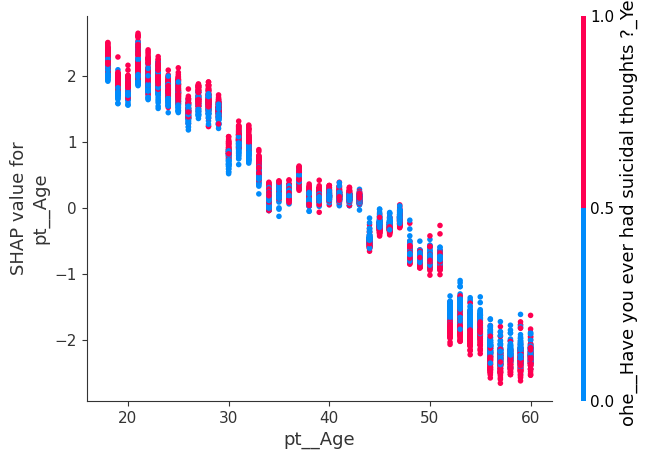

In [706]:
shap.dependence_plot('pt__Age', shap_values, X)

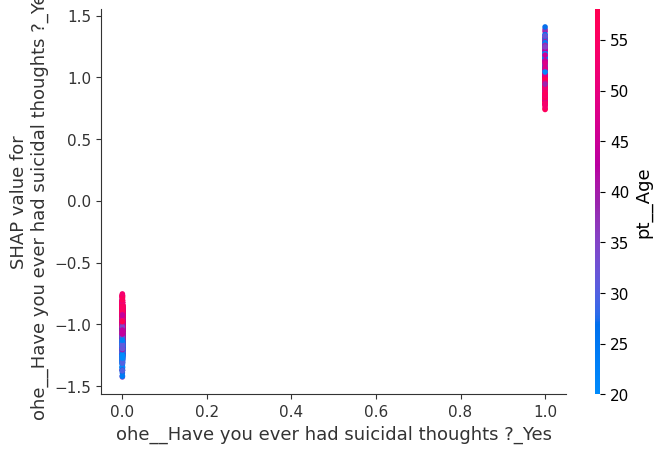

In [707]:
shap.dependence_plot('ohe__Have you ever had suicidal thoughts ?_Yes', shap_values, X)

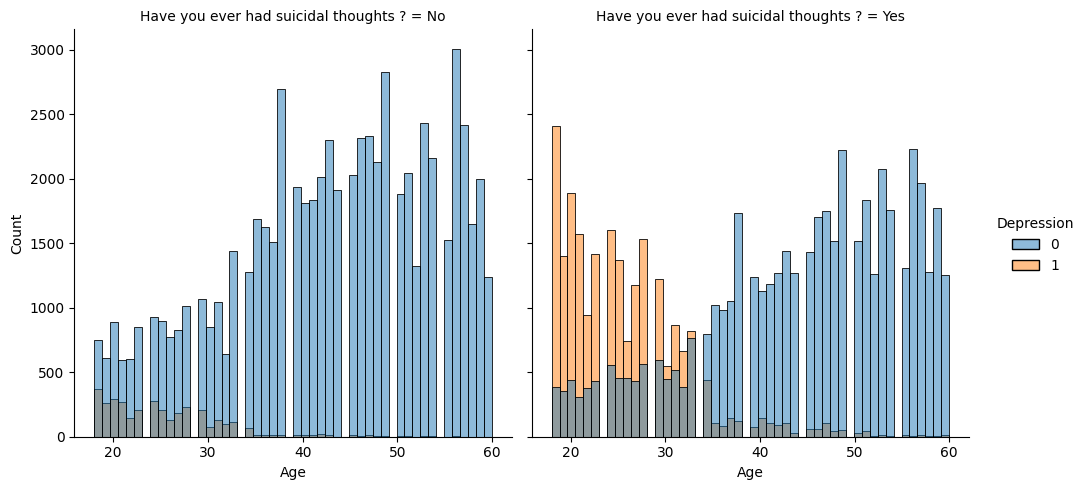

In [60]:
sns.displot(df_train, x='Age', col='Have you ever had suicidal thoughts ?', hue=target, height=5)

Have you ever had suicidal thoughts ? 은 Age가 작을 수록 Depression에 주는 영향이 큽니다.

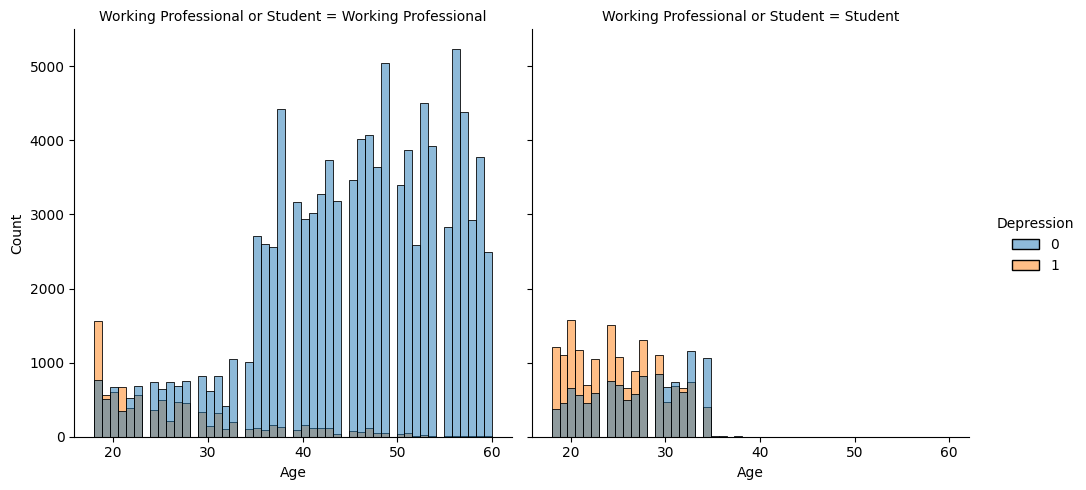

In [61]:
sns.displot(df_train, x='Age', col='Working Professional or Student', hue=target, height=5)

Age가 36 이하에 학생이 집중되어 있습니다.

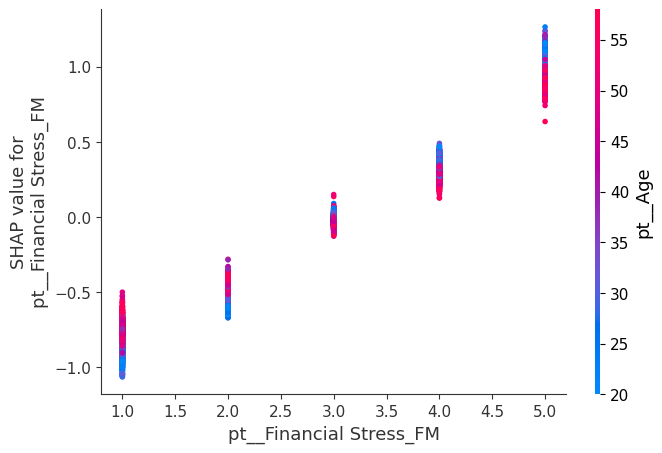

In [636]:
shap.dependence_plot('pt__Financial Stress_FM', shap_values, X)

## Profession_R2 & Degree_R

In [68]:
df_train.groupby('Profession_R2', observed=True)[target].mean().sort_values(ascending=False).iloc[:5]

Profession_R2
Student             0.585415
Unknown             0.375100
Graphic Designer    0.185727
Judge               0.108645
HR Manager          0.106912
Name: Depression, dtype: float64

In [69]:
df_train.groupby('Degree_R', observed=True)[target].agg(['mean', 'count']).sort_values('mean', ascending=False).iloc[:10]

,mean,count
Degree_R,,
Class 12,0.512526,14729
Noise,0.232759,116
B.Tech,0.214011,4425
BCA,0.203868,5739
BE,0.190077,3104
MA,0.175268,2887
MSc,0.174011,4879
BHM,0.172590,4305
MBBS,0.170019,3082


In [70]:
df_train.query("Profession_R2 == 'Student'").groupby('Degree_R', observed=True)[target].agg(['mean', 'count']).iloc[:10]

,mean,count
Degree_R,,
Noise,0.600000,35
Class 12,0.707730,6080
B.Ed,0.546867,1867
B.Arch,0.589310,1478
B.Com,0.566025,1507
B.Pharm,0.528395,810
BCA,0.571528,1433
M.Ed,0.505481,821
MCA,0.535441,1044


In [71]:
df_train.query("Profession_R2 != 'Student'").groupby('Degree_R', observed=True)[target].agg(['mean', 'count']).iloc[:10]

,mean,count
Degree_R,,
Noise,0.074074,81
Class 12,0.375304,8649
B.Ed,0.049267,9824
B.Arch,0.069659,7264
B.Com,0.062065,6606
B.Pharm,0.053508,5046
BCA,0.081514,4306
M.Ed,0.028059,4847
MCA,0.049881,4190


In [72]:
df_train.query("Profession_R2 == 'Unknown'").groupby('Degree_R', observed=False)[target].agg(['mean', 'count']).iloc[:10]

,mean,count
Degree_R,,
Noise,0.375000,8
Class 12,0.374854,8590
B.Ed,0.545455,11
B.Arch,0.384615,13
B.Com,0.333333,6
B.Pharm,0.800000,5
BCA,0.400000,10
M.Ed,0.200000,5
MCA,0.250000,8


학생 여부에 따라 Degree_R의 target의 차이가 크게 납니다. 이 둘을 결합한 범주형 변수를 만들어 볼만 합니다.

In [465]:
combine_WS_Suicidal = lambda x: dproc.combine_cat(x[['Working Professional or Student', 'Have you ever had suicidal thoughts ?']], '_').rename('WS_Suicidal')
combine_WS_Degree_proc = lambda x: dproc.combine_cat(x[['Working Professional or Student', 'Degree_R']], '_').rename('WS_Degree')
combine_Prof_Degree_proc = lambda x: dproc.combine_cat(x[['Profession_R2', 'Degree_R']], '_').rename('Prof_Degree')
combine_cat_procs = [
    (combine_WS_Suicidal, "Working Professional or Student와 Have you ever had suicidal thoughts ?을 결합합니다."),
    (combine_WS_Degree_proc, "Working Professional or Student와 Degree_R을 결합합니다."),
    (combine_Prof_Degree_proc, "Profession_R2과 Degree_R을 결합합니다."),
]

df_combine_cat, df_combine_cat_procs_var = sc.cache_result('combine_cat_procs', lambda : dproc.apply_pd(df_train, combine_cat_procs, 'combine_cat'))
df_train = dproc.join_and_assign(df_train, df_combine_cat)
df_var = pd.concat([df_var, df_combine_cat_procs_var], axis=0).groupby(level=0).last()
del df_combine_cat, df_combine_cat_procs_var
df_var.query('src == "combine_cat"')

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
Prof_Degree,None,None,0.0,140700.0,602.0,None,None,None,None,None,Categorical,Profession_R2과 Degree_R을 결합합니다.,combine_cat,<function <lambda> at 0x7fd7580b1c60>
WS_Degree,None,None,0.0,140700.0,56.0,None,None,None,None,None,Categorical,Working Professional or Student와 Degree_R을 결합합니다.,combine_cat,<function <lambda> at 0x7fd7588d8d60>
WS_Suicidal,None,None,0.0,140700.0,4.0,None,None,None,None,None,Categorical,Working Professional or Student와 Have you ever...,combine_cat,<function <lambda> at 0x7fd79ce9e340>


## XGB

In [674]:
hparams = {
    'model_params': {'n_estimators': 1200, 'learning_rate': 0.03, 'max_depth': 5, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50},
    'validation_fraction': 0.1
}

result = sc.cache_result(
    'simple_xgb',
    lambda : sgml.cv(df_train, skf, hparams, config, xgb_adapter)
)
np.mean(result['valid_scores'])

Round:   0%|          | 0/1200 [00:00<?, ?it/s]

Round:   0%|          | 0/1200 [00:00<?, ?it/s]

Round:   0%|          | 0/1200 [00:00<?, ?it/s]

Round:   0%|          | 0/1200 [00:00<?, ?it/s]

Round:   0%|          | 0/1200 [00:00<?, ?it/s]

0.9396659559346127

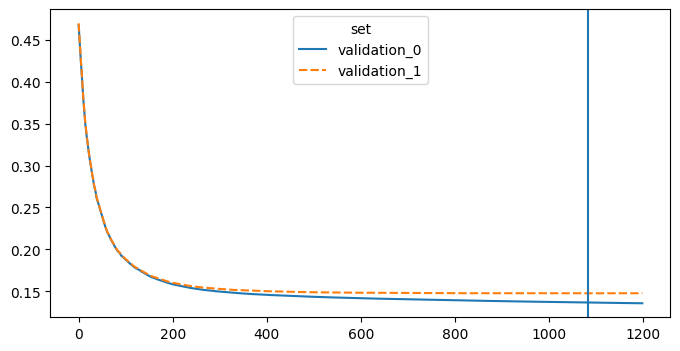

In [675]:
plt.figure(figsize=(8, 4))
valid_result = pd.concat([i['valid_result'] for i in result['model_result']], axis=1).T.groupby(level=1).mean().T
sns.lineplot(valid_result)
plt.axvline(valid_result['validation_1'].idxmin())
plt.show()

In [677]:
result = sc.cache_result(
    'simple_xgb',
    lambda : sgml.train(df_train, hparams, config, xgb_adapter)
)

Round:   0%|          | 0/1200 [00:00<?, ?it/s]

In [683]:
def get_shap_interaction_values():
    ct = result[0]['preprocessor']
    df_sub = df_train.sample(frac=0.01, random_state=123)
    X = pd.DataFrame(ct.transform(df_sub).todense(), index=df_sub.index, columns=result[0]['variables'])
    shap_values = shap.TreeExplainer(result[0]['model']).shap_interaction_values(X)
    return shap_values, df_sub, X

shap_interaction_values, df_sub, X = sc.cache_result(
    'xgb_shap_interaction_values', get_shap_interaction_values, 1
)

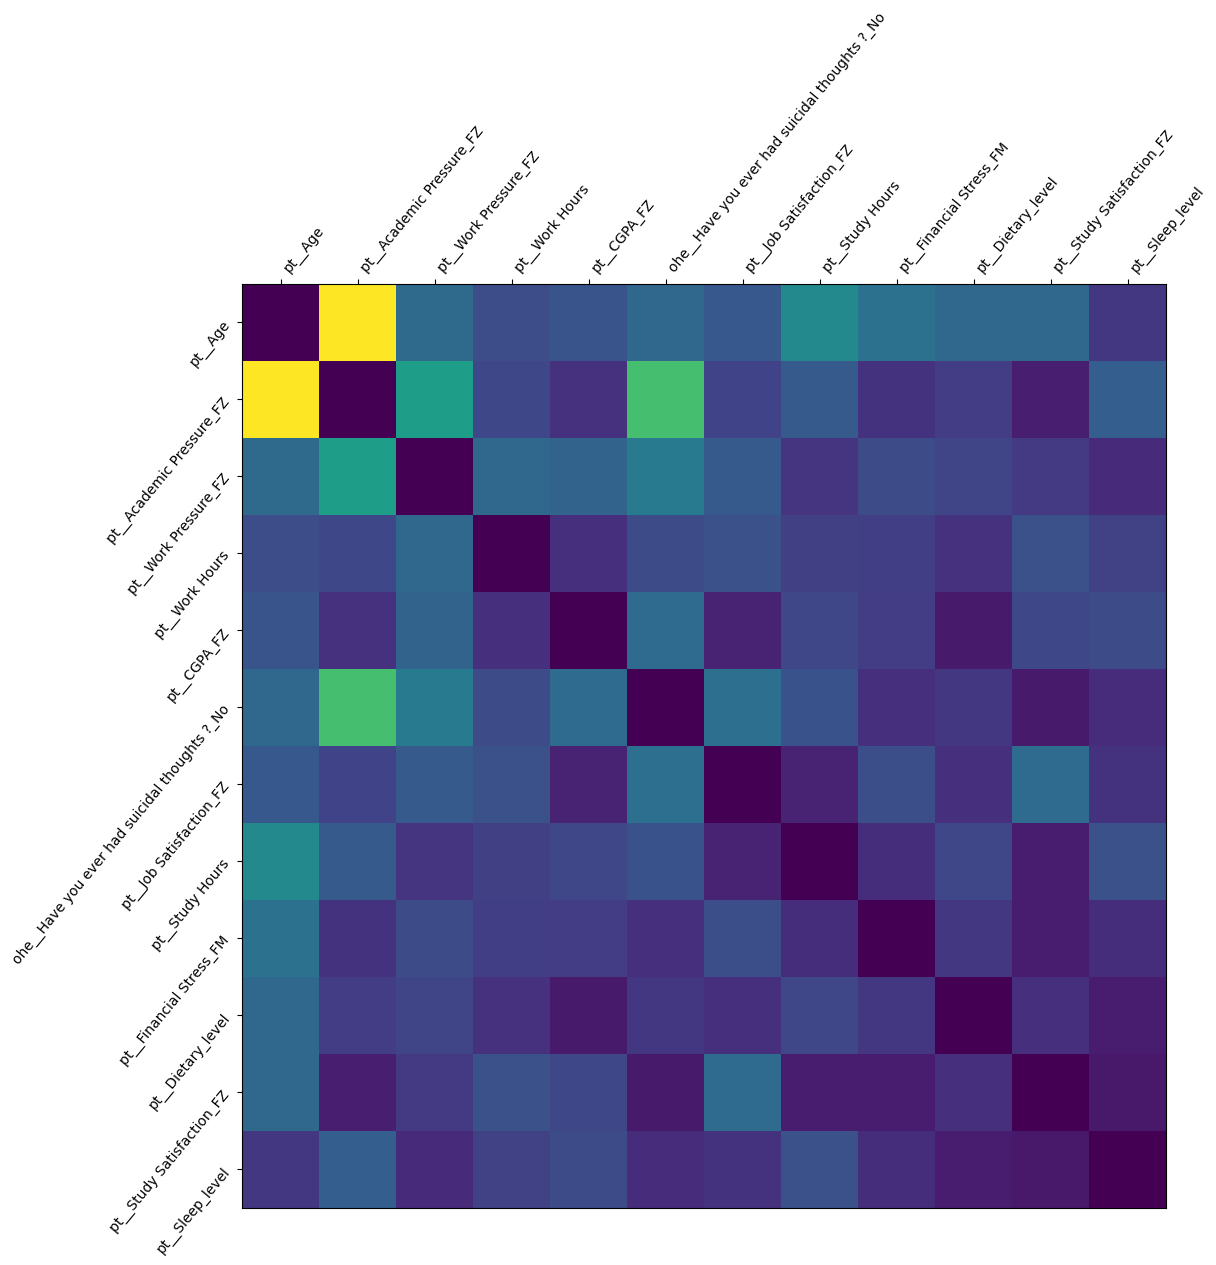

In [684]:
interaction_matrix = np.abs(shap_interaction_values).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:12]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(12, 12))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

LDA를 사용한 모델은 Tree를 더 Weak하게 만들면 효과를 기대할 만합니다.

# Truncated SVD

City_R, Degree_R, Name_R, Profession_R 서로 연관성이 높습니다. 이들을 가변수화하여 TruncatedSVD를 사용하여 축소하여 패턴을 단순화시켜봅니다.

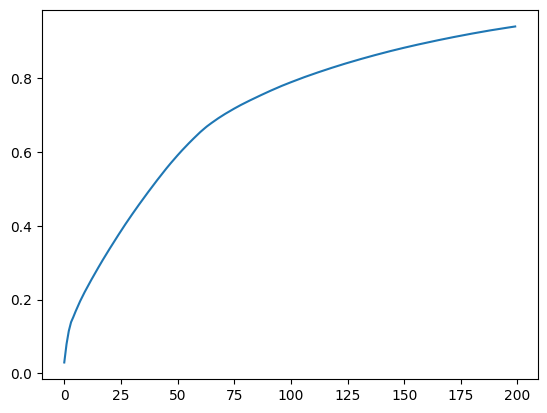

In [97]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

tsvd = sc.cache_result('tsvd_model', 
    lambda : make_pipeline(OneHotEncoder(drop='first'), TruncatedSVD(200)).fit(df_train[['City_R', 'Degree_R', 'Name_R', 'Profession_R2']]), rerun=True
)
sns.lineplot(tsvd[1].explained_variance_ratio_.cumsum())
plt.show()

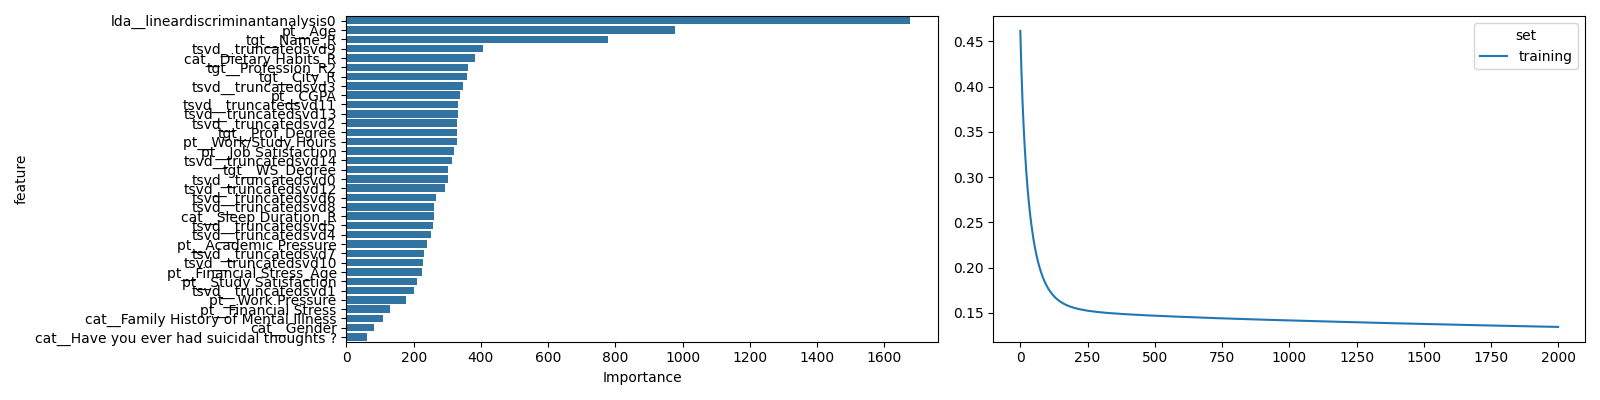

Accuracy, train: 0.94383±0.00000
Accuracy, valid: 0.93810±0.00000


In [98]:
X_lgb_tgt = ['Name_R', 'Profession_R2', 'City_R', 'WS_Degree', 'Prof_Degree']
X_tsvd = ['City_R', 'Degree_R', 'Name_R', 'Profession_R2']
X_lgb_cat2 = ['City_R', 'Dietary Habits_R', 'Profession_R2', 'Sleep Duration_R', 'WS_Degree', 'Name_R', 'Prof_Degree']
X_lgb_cat3 = [i for i in X_lgb_cat2 if i not in X_lgb_tgt]
X_lgb_bool2 =['Family History of Mental Illness', 'Gender', 'Have you ever had suicidal thoughts ?']

result = do_lgb_exp(
    'LGBM_tgt_enc_lda_tsvd', {
        'model_params': {'n_estimators': 2000, 'learning_rate': 0.02, 'num_leaves': 7, 'random_state': 123}, 
        'X_cat': X_lgb_cat3 + X_lgb_bool2, 'X_tgt': X_lgb_tgt, 
        'lda': {'X_mm': ["Pressure", "Satisfaction", "Work/Study Hours", "Age", "Financial Stress_FM"], 'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe': {'drop': 'first'}},
        'tsvd': {'X_ohe': X_tsvd, 'ohe': {'drop': 'first'}, 'hparams': {'n_components': 15}},
        'X_num': X_lgb_num_na + X_lgb_num + ['Financial Stress_Age']
    }
)

위 실험 결과로 미루어 보아 TSVD 사용해볼만 합니다.

# 변수 정리

In [166]:
df_var.query('src != "org"').sort_values('src')

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
Profession_R,None,None,0.0,140700.0,38.0,None,None,None,None,None,Categorical,Profession에서 train과 test에서 빈도가 10 미만은 Noise 처리...,cat_proc,<function get_prof_proc.<locals>.<lambda> at 0...
City_R,None,None,0.0,140700.0,31.0,None,None,None,None,None,Categorical,City에서 train과 test에서 빈도가 10 미만은 Noise 처리합니다.,cat_proc,<function get_city_proc.<locals>.<lambda> at 0...
Degree_R,None,None,0.0,140700.0,28.0,None,None,None,None,None,Categorical,"Degree에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, ...",cat_proc,<function get_degree_proc.<locals>.<lambda> at...
Dietary Habits_R,None,None,0.0,140700.0,4.0,None,None,None,None,None,Categorical,Dietary Habits에서 train과 test에서 최대한 유사 빈도의 카테고리...,cat_proc,<function get_dietary_proc.<locals>.<lambda> a...
Name_R,None,None,0.0,140700.0,218.0,None,None,None,None,None,Categorical,Name에서 train과 test에서 빈도가 20 미만은 Noise 처리합니다.,cat_proc,<function get_name_proc.<locals>.<lambda> at 0...
Sleep Duration_R,None,None,0.0,140700.0,5.0,None,None,None,None,None,Categorical,Sleep Duration에서 train과 test에서 최대한 유사 빈도의 카테고리...,cat_proc,<function get_sleep_proc.<locals>.<lambda> at ...
Financial Stress_Age,-48.0,48.0,0.0,140700.0,73.0,True,True,True,True,None,Float32,Age와 Financial Stresss를 중심평균화 한 후 곱합니다.,combine,<function <lambda> at 0x7f6c18200860>
Pressure,1.0,5.0,0.0,140700.0,5.0,True,True,True,True,None,Float32,Academic Pressure와 Work Pressure을 결합합니다.,combine,<function <lambda> at 0x7f6c08f4ad40>
Satisfaction,1.0,5.0,0.0,140700.0,5.0,True,True,True,True,None,Float32,Job Satisfaction와 Study Satisfaction을 결합합니다.,combine,<function <lambda> at 0x7f6c18200ae0>
WS_Suicidal,None,None,0.0,140700.0,4.0,None,None,None,None,None,Categorical,Working Professional or Student와 Have you ever...,combine_cat,<function <lambda> at 0x7f6c086c5120>


In [167]:
df_test, nq = dproc.apply_pd_procs(df_test, df_var.loc[df_var['processor'].notna(), 'processor'])
df_test

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Pressure,Name_R,Job Satisfaction_FZ,Financial Stress_FM,Financial Stress_Age,Dietary Habits_R,Degree_R,City_R,CGPA_FZ,Academic Pressure_FZ
id,,,,,,,,,,,,,,,,,,,,,
140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,...,2.0,Shivam,5,3,0.0,Moderate,LLB,Visakhapatnam,0.00,0
140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,...,2.0,Sanya,4,4,22.0,Moderate,B.Ed,Kolkata,0.00,0
140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,...,4.0,Yash,1,4,17.0,Moderate,B.Arch,Jaipur,0.00,0
140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,...,5.0,Nalini,0,4,-13.0,Moderate,BSc,Rajkot,6.84,5
140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,...,5.0,Shaurya,5,4,11.0,Moderate,BCA,Kalyan,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234495,Zoya,Female,49.0,Jaipur,Working Professional,Pilot,NaN,3.0,NaN,NaN,...,3.0,Zoya,5,2,-13.0,Moderate,BSc,Jaipur,0.00,0
234496,Shlok,Male,29.0,Ahmedabad,Working Professional,Pilot,NaN,5.0,NaN,NaN,...,5.0,Shlok,1,3,-0.0,Moderate,BE,Ahmedabad,0.00,0
234497,Rishi,Male,24.0,Visakhapatnam,Student,NaN,1.0,NaN,7.51,4.0,...,1.0,Rishi,0,1,24.0,Moderate,B.Tech,Visakhapatnam,7.51,1


In [151]:
df_train.loc[:, df_train.columns.isin(df_var.index)].to_feather(os.path.join('data', 'train_w.feather'))

In [169]:
with open(os.path.join('data', 'var_w.dill'), 'wb') as f:
    dill.dump(df_var, f)